In [2]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import scipy

from sklearn.cluster import DBSCAN

In [2]:
import os
path = './all/'
count = 0
for root,dirs,files in os.walk(path):
      for each in files:
          if each.endswith('png'):
             count += 1
print ("圖片數量：",count)

圖片數量： 54415


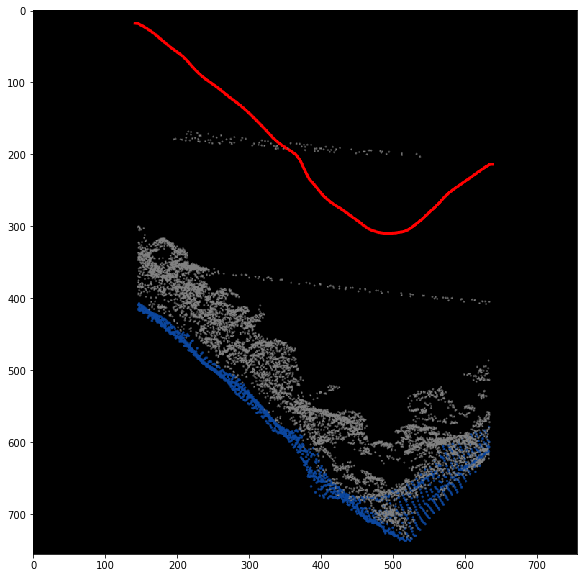

In [9]:
file='9520-1-053_100.png'
img=cv2.imread(path+file)
plt.figure(figsize=(10,10))
plt.imshow(img)

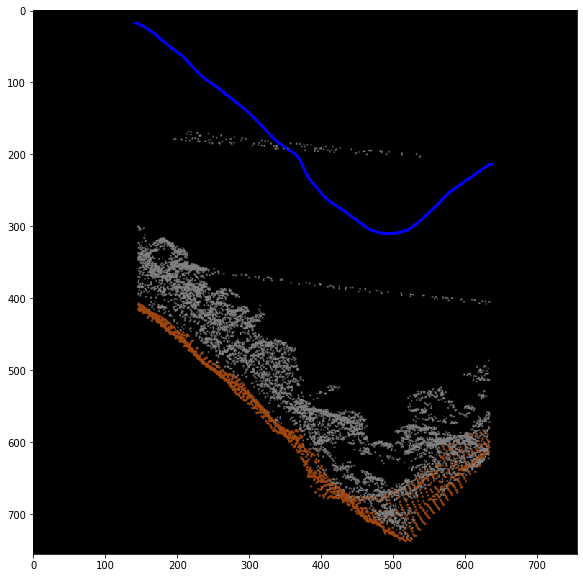

In [10]:
file='9520-1-053_100.png'
img=cv2.imread(path+file)
img = img[ : , : , (2, 1, 0)] # BGR2RGB
plt.figure(figsize=(10,10))
plt.imshow(img)

# 1. Data Exploration
## RGB 分布

In [11]:
img.shape

(756, 756, 3)

In [12]:
imgf=img.reshape(756*756,3)
imgf.shape

(571536, 3)

In [13]:
L=[]
for i in imgf:
    if(i.tolist() not in L):
        L.append(i.tolist())

In [14]:
LC=[]
for j in L:
    s=0
    for i in imgf:
        if(i.tolist()==j):
            s+=1
    LC.append(s)

In [15]:
print(len(L),len(LC))

61 61


In [16]:
L

[[0, 0, 0],
 [0, 0, 159],
 [0, 0, 127],
 [0, 0, 96],
 [0, 0, 64],
 [0, 0, 32],
 [0, 0, 255],
 [0, 0, 223],
 [0, 0, 191],
 [32, 32, 32],
 [48, 48, 48],
 [96, 96, 96],
 [80, 80, 80],
 [16, 16, 16],
 [64, 64, 64],
 [128, 128, 128],
 [112, 112, 112],
 [16, 16, 175],
 [32, 32, 159],
 [32, 32, 223],
 [48, 48, 207],
 [64, 64, 160],
 [96, 96, 128],
 [32, 32, 191],
 [64, 64, 191],
 [79, 35, 5],
 [118, 52, 8],
 [39, 17, 3],
 [158, 70, 11],
 [138, 61, 10],
 [59, 26, 4],
 [99, 44, 7],
 [127, 83, 53],
 [20, 9, 1],
 [147, 92, 55],
 [135, 113, 99],
 [150, 84, 40],
 [131, 76, 39],
 [123, 90, 68],
 [55, 33, 19],
 [115, 60, 23],
 [143, 99, 69],
 [87, 65, 51],
 [95, 51, 21],
 [84, 73, 65],
 [154, 77, 26],
 [68, 57, 49],
 [100, 89, 81],
 [71, 49, 35],
 [132, 121, 113],
 [36, 25, 17],
 [134, 68, 24],
 [119, 97, 83],
 [91, 58, 36],
 [139, 106, 84],
 [116, 105, 97],
 [52, 41, 33],
 [103, 81, 67],
 [75, 42, 20],
 [107, 74, 52],
 [111, 67, 37]]

In [17]:
LC

[524252,
 58,
 290,
 74,
 117,
 301,
 1936,
 323,
 113,
 3659,
 3756,
 3685,
 3887,
 3700,
 3690,
 7046,
 3448,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 666,
 951,
 461,
 3392,
 1347,
 663,
 786,
 69,
 558,
 161,
 188,
 131,
 65,
 71,
 39,
 53,
 164,
 60,
 51,
 53,
 128,
 49,
 93,
 39,
 192,
 31,
 77,
 92,
 50,
 198,
 81,
 34,
 48,
 48,
 52,
 48]

## Data Exploration Result:
* 1.像素並非只有4種: (0,0,0), (R,0,0), (0,0,B), (R,G,B), 而是多種組合. 無法直接分割.
* 2.無法直接取白線做 Hough Transform取電線
* 3.無法直接去除藍線(基準線)與橘線(地表), 做KNN

### 嘗試: 
* B>>R & G:(0,0,B)
* R>>G & B:(R,0,0)
* R=B=G: (255,255,255)
* keep (0,0,0)

# 2. Data Preprocess
* (0,0,B):(0,0,255)
* (R,0,0):(255,0,0)
* R=B=G & R/G/B<>0: (255,255,255) & keep (0,0,0)
* B>R & G:(0,0,B)
* R>G & B:(R,0,0)

In [18]:
file='9520-1-053_100.png'
img=cv2.imread(path+file)
img = img[ : , : , (2, 1, 0)]

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if((img[i][j][2]!=0) and (img[i][j][0]==0) and (img[i][j][1]==0)): # (0,0,B):(0,0,255)
            img[i][j][2]=255
        if((img[i][j][0]!=0) and (img[i][j][1]==0) and (img[i][j][2]==0)):# (R,0,0):(255,0,0)
            img[i][j][0]=255
        if((img[i][j][0]==img[i][j][1]) and (img[i][j][1]==img[i][j][2]) and (img[i][j][0]!=0)): # R=B=G: (255,255,255) & keep (0,0,0)
            img[i][j][0]=255;img[i][j][1]=255;img[i][j][2]=255      

        if(img[i][j][2]>img[i][j][1]):
            if(img[i][j][2]>img[i][j][0]):
                img[i][j][1]=0;img[i][j][0]=0;img[i][j][2]=255 # B>R & G:(0,0,B)
        if(img[i][j][0]>img[i][j][1]):
            if(img[i][j][0]>img[i][j][2]):
                img[i][j][1]=0;img[i][j][2]=0;img[i][j][0]=255 # R>G & B:(R,0,0)

In [19]:
imgf=img.reshape(756*756,3)
imgf.shape
L=[]
for i in imgf:
    if(i.tolist() not in L):
        L.append(i.tolist())
L

[[0, 0, 0], [0, 0, 255], [255, 255, 255], [255, 0, 0]]

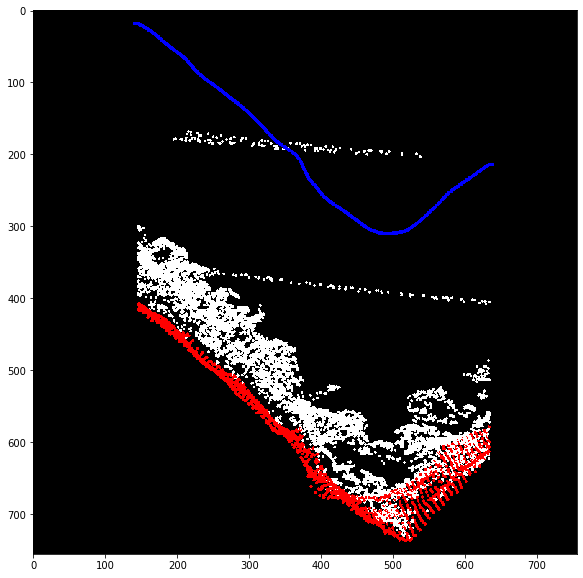

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(img)

## 檢視特定圖片Image Preprocess結果

(-0.5, 755.5, 755.5, -0.5)

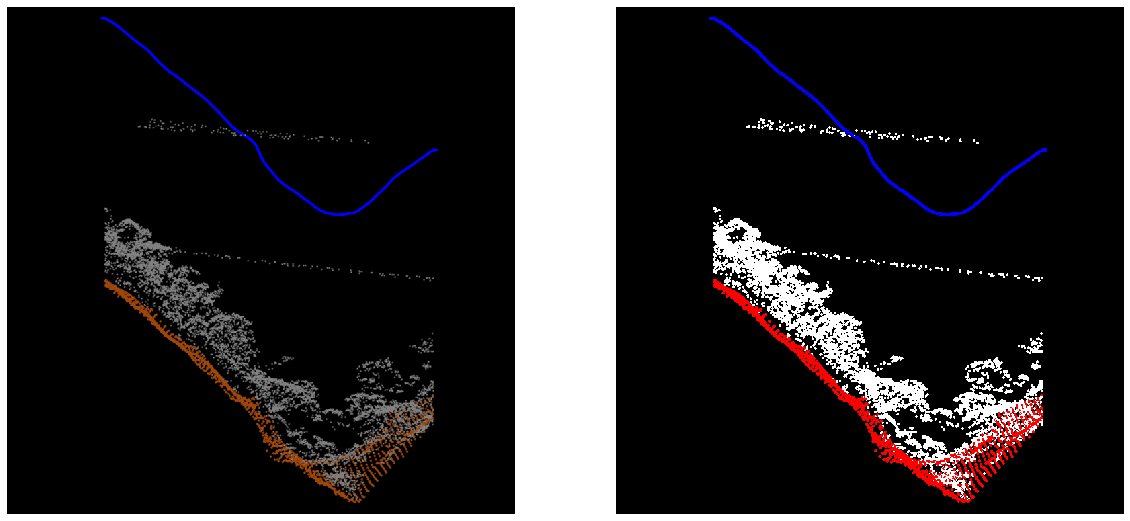

In [21]:
file='9520-1-053_100.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img0);plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img);plt.axis('off')

(-0.5, 755.5, 755.5, -0.5)

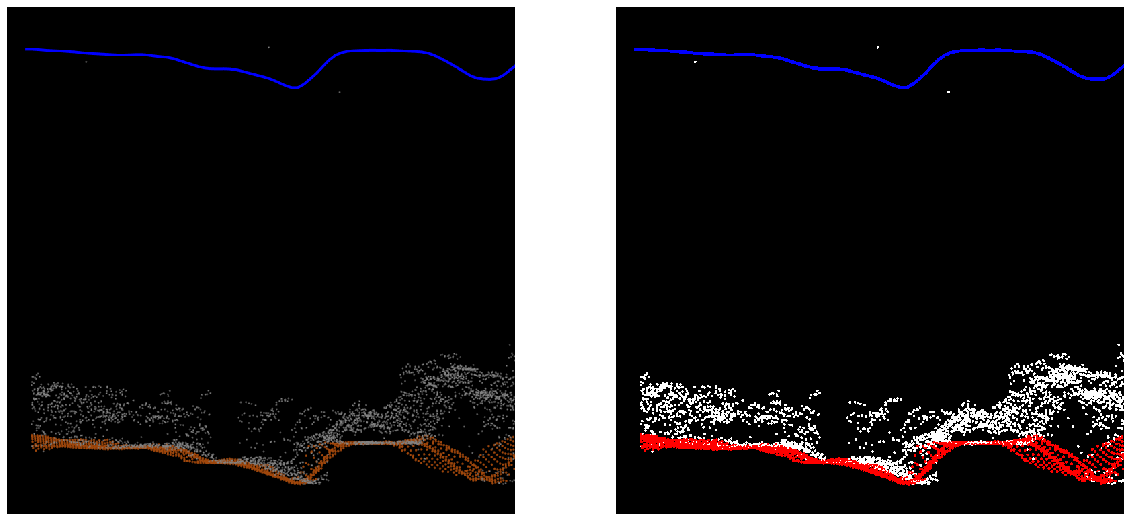

In [22]:
file='9418-1-035_001.png'
img=cv2.imread(path+file)
img = img[ : , : , (2, 1, 0)]

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if((img[i][j][2]!=0) and (img[i][j][0]==0) and (img[i][j][1]==0)):
            img[i][j][2]=255
        if((img[i][j][0]!=0) and (img[i][j][1]==0) and (img[i][j][2]==0)):
            img[i][j][0]=255
        if((img[i][j][0]==img[i][j][1]) and (img[i][j][1]==img[i][j][2]) and (img[i][j][0]!=0)):
            img[i][j][0]=255;img[i][j][1]=255;img[i][j][2]=255      

        if(img[i][j][2]>img[i][j][1]):
            if(img[i][j][2]>img[i][j][0]):
                img[i][j][1]=0;img[i][j][0]=0;img[i][j][2]=255
        if(img[i][j][0]>img[i][j][1]):
            if(img[i][j][0]>img[i][j][2]):
                img[i][j][1]=0;img[i][j][2]=0;img[i][j][0]=255

img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img0);plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img);plt.axis('off')

## 隨機取圖片check Image Preprocess 結果

In [3]:
# read all img file
path = './all/'
img_file=[]
for root,dirs,files in os.walk(path):
      for each in files:
            if each.endswith('png'):
                img_file.append(each)

(-0.5, 755.5, 755.5, -0.5)

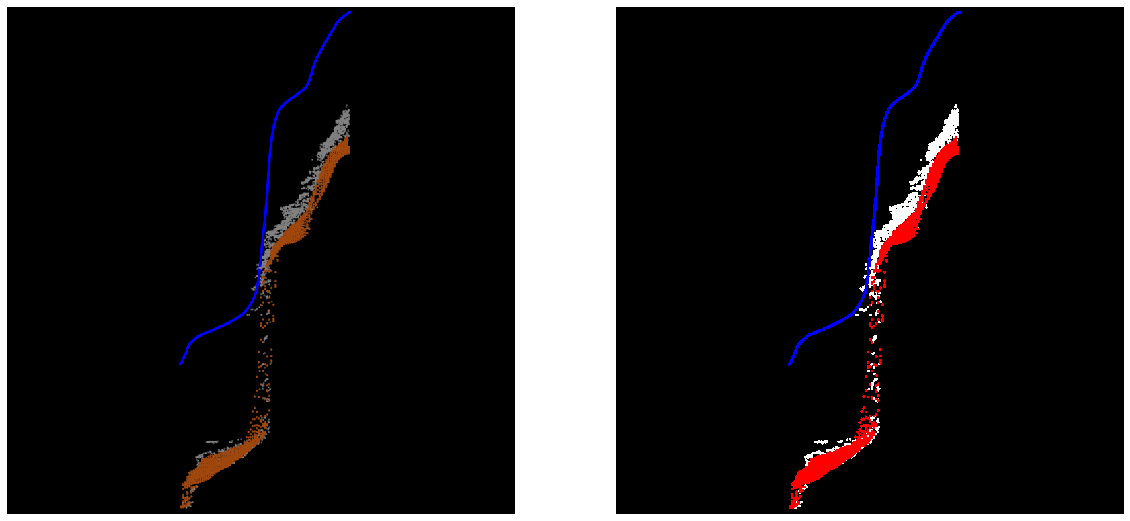

In [24]:
from numpy.random import randint
ix = randint(0, count, 1)
file=img_file[ix[0]]
img=cv2.imread(path+file)
img = img[ : , : , (2, 1, 0)]

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if((img[i][j][2]!=0) and (img[i][j][0]==0) and (img[i][j][1]==0)):
            img[i][j][2]=255
        if((img[i][j][0]!=0) and (img[i][j][1]==0) and (img[i][j][2]==0)):
            img[i][j][0]=255
        if((img[i][j][0]==img[i][j][1]) and (img[i][j][1]==img[i][j][2]) and (img[i][j][0]!=0)):
            img[i][j][0]=255;img[i][j][1]=255;img[i][j][2]=255      

        if(img[i][j][2]>img[i][j][1]):
            if(img[i][j][2]>img[i][j][0]):
                img[i][j][1]=0;img[i][j][0]=0;img[i][j][2]=255
        if(img[i][j][0]>img[i][j][1]):
            if(img[i][j][0]>img[i][j][2]):
                img[i][j][1]=0;img[i][j][2]=0;img[i][j][0]=255

img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img0);plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img);plt.axis('off')

In [3]:
def img_pre(img):
    img = img[ : , : , (2, 1, 0)]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if((img[i][j][2]!=0) and (img[i][j][0]==0) and (img[i][j][1]==0)):
                img[i][j][2]=255
            if((img[i][j][0]!=0) and (img[i][j][1]==0) and (img[i][j][2]==0)):
                img[i][j][0]=255
            if((img[i][j][0]==img[i][j][1]) and (img[i][j][1]==img[i][j][2]) and (img[i][j][0]!=0)):
                img[i][j][0]=255;img[i][j][1]=255;img[i][j][2]=255      

            if(img[i][j][2]>img[i][j][1]):
                if(img[i][j][2]>img[i][j][0]):
                    img[i][j][1]=0;img[i][j][0]=0;img[i][j][2]=255
            if(img[i][j][0]>img[i][j][1]):
                if(img[i][j][0]>img[i][j][2]):
                    img[i][j][1]=0;img[i][j][2]=0;img[i][j][0]=255
    return img

In [5]:
def img_compare(img_file,path):
    ix = randint(0, count, 1)
    file=img_file[ix[0]]
    img=cv2.imread(path+file)
    img=img_pre(img)
    img0=cv2.imread(path+file)
    img0 = img0[ : , : , (2, 1, 0)]
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img0);plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img);plt.axis('off')
    print(file)

9519-4-061_159.png


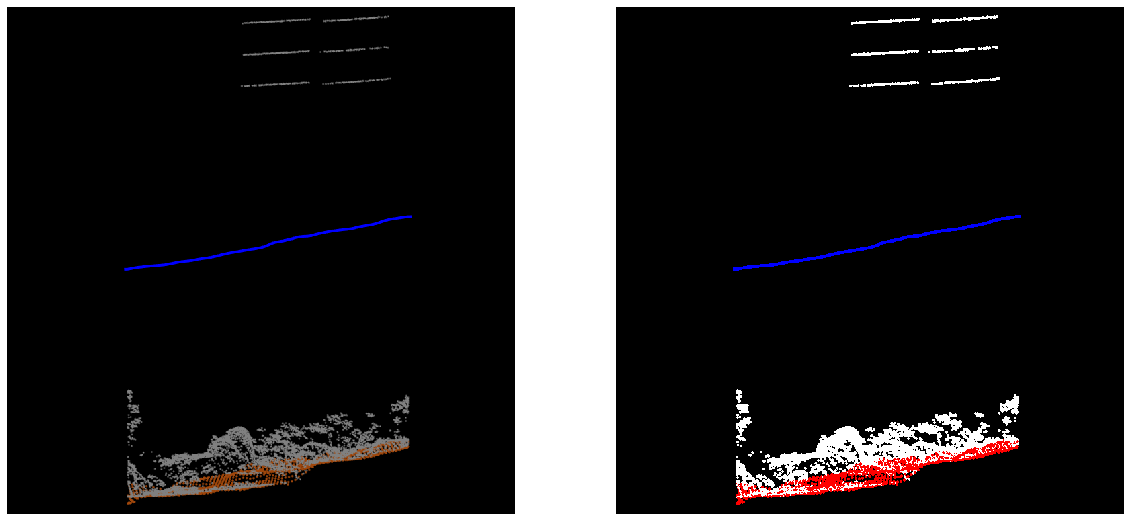

In [27]:
img_compare(img_file,path)

9620-3-062_007.png


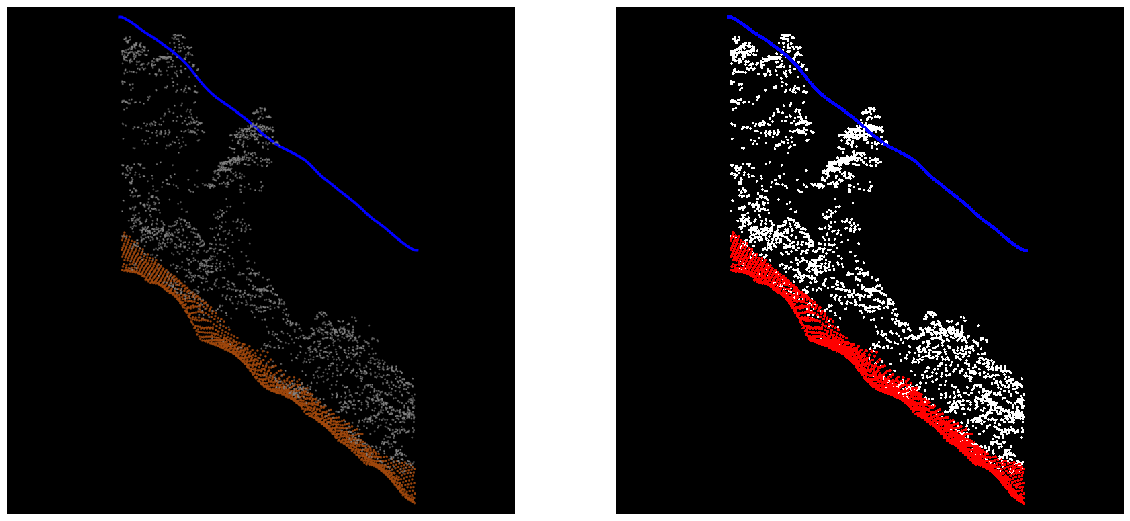

In [81]:
img_compare(img_file,path)

9518-1-067_023.png


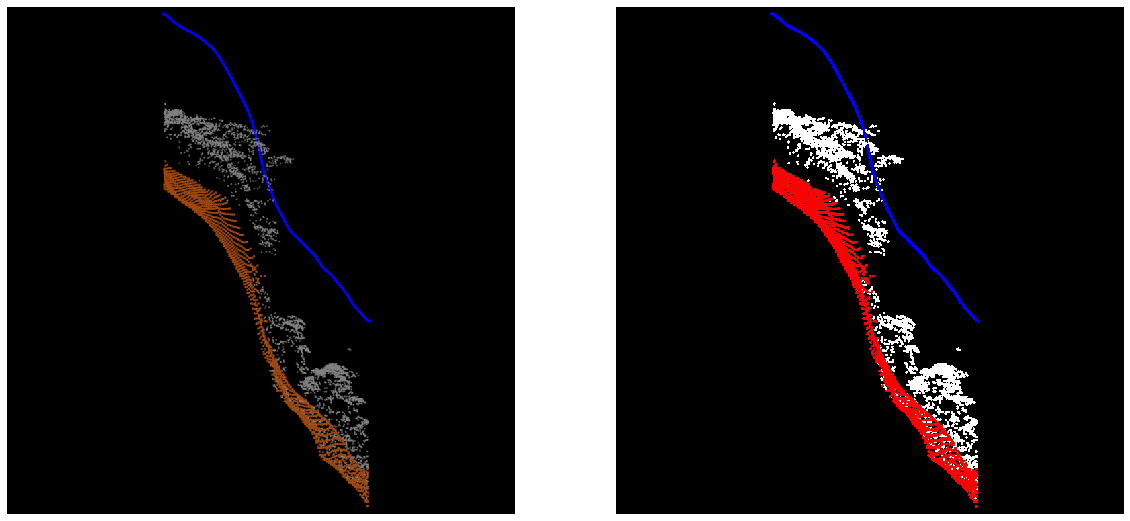

In [82]:
img_compare(img_file,path)

9619-4-024_204.png


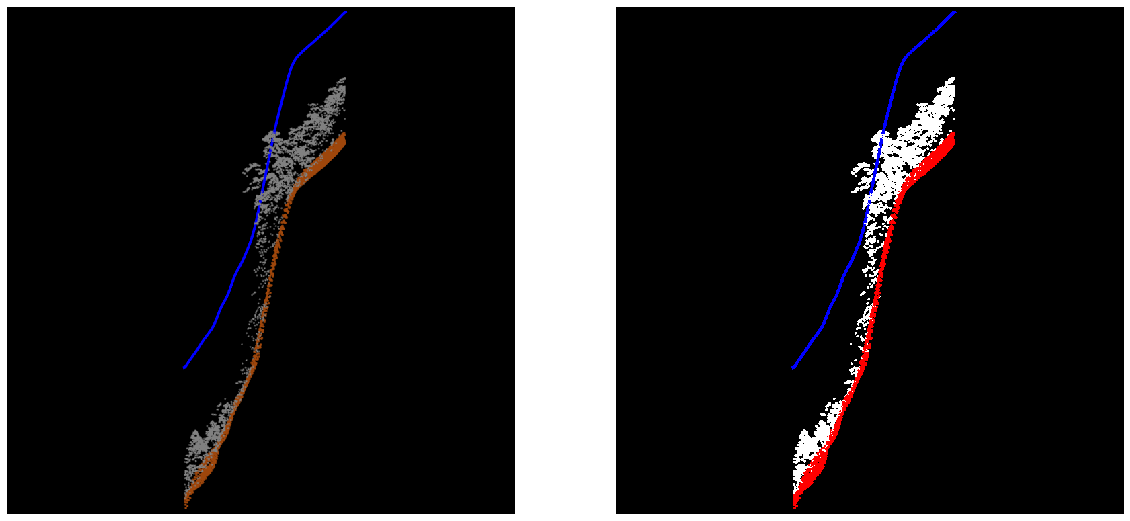

In [83]:
img_compare(img_file,path)

9619-3-073_007.png


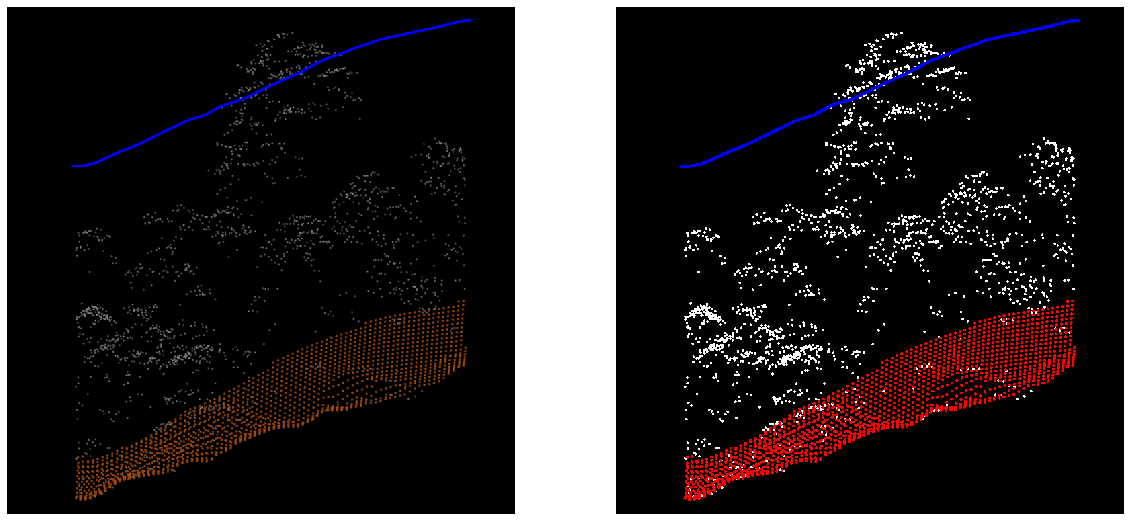

In [84]:
img_compare(img_file,path)

9518-4-020_019.png


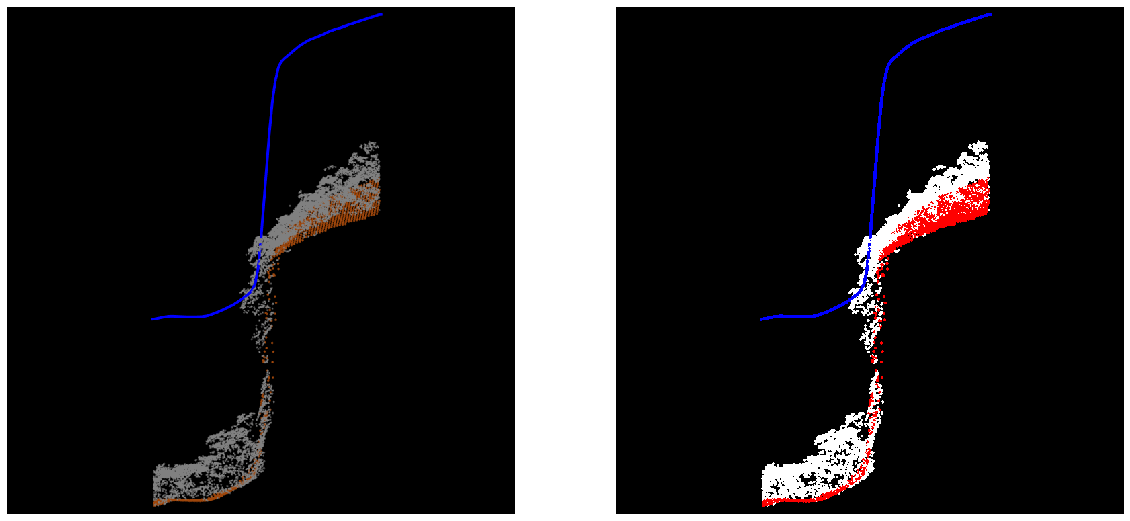

In [87]:
img_compare(img_file,path)

# 3. Cluster-KMean/DBSCAN test
只取白線做DBSCAN

## Tes Image

(-0.5, 755.5, 755.5, -0.5)

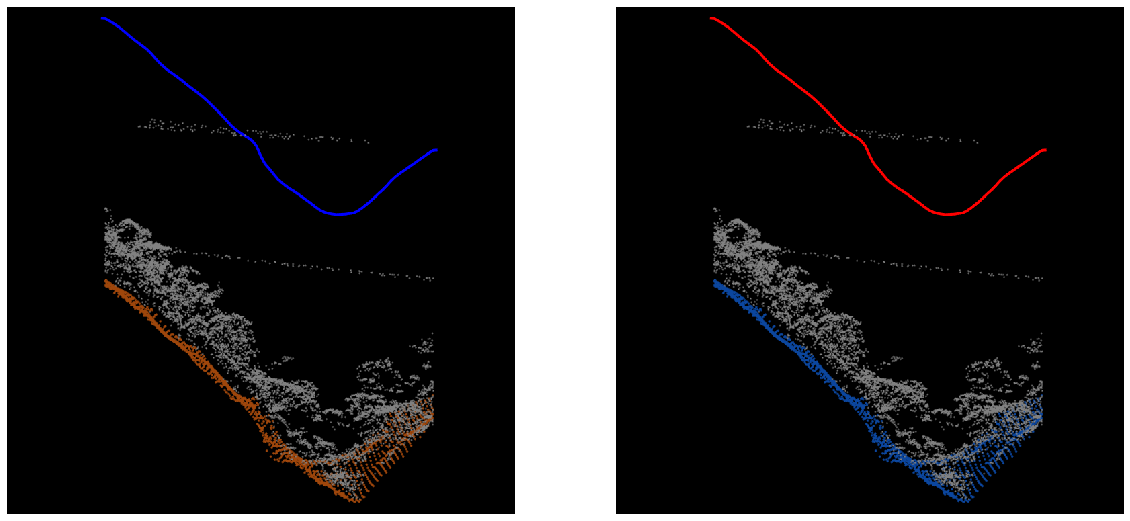

In [28]:
file='9520-1-053_100.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
img=cv2.imread(path+file)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img0);plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img);plt.axis('off')

## Image Preprocess

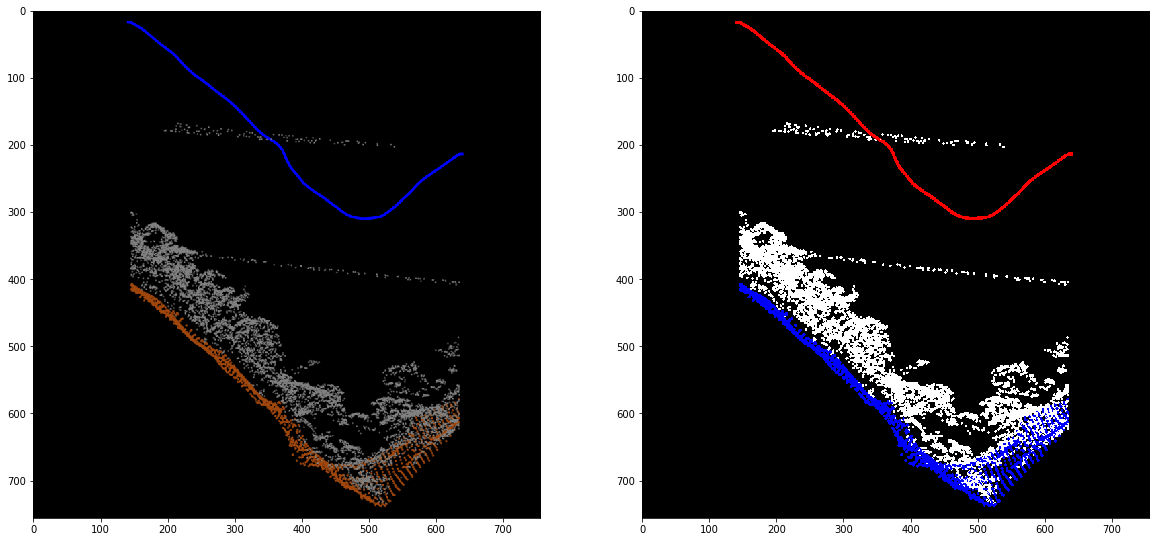

In [39]:
imgp=img_pre(img0)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img0)#;plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(imgp)#;plt.axis('off')

## 取白點座標

In [47]:
coor=[]
for i in range(imgp.shape[0]):
    for j in range(imgp.shape[1]):
        if((imgp[i][j][0]==255) and (imgp[i][j][1]==255) and (imgp[i][j][2]==255)):
            coor.append([j,i])

In [50]:
X=np.array(coor)

## Kmean

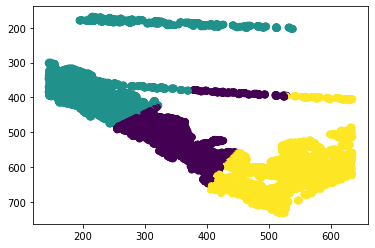

In [52]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(X)
ax = plt.gca() 
ax.invert_yaxis()
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

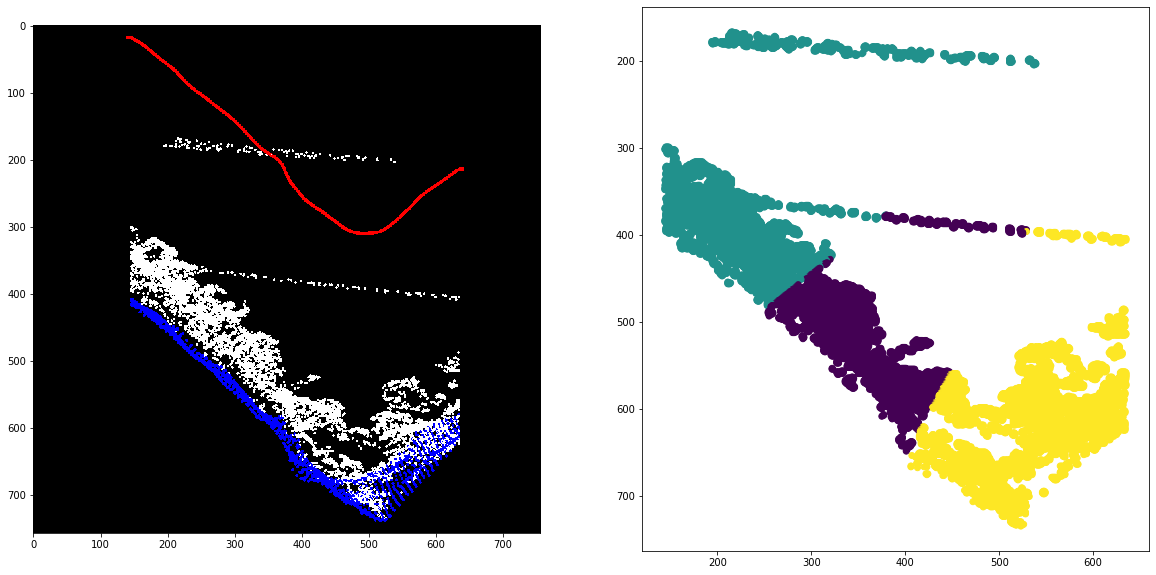

In [53]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(imgp)#;plt.axis('off')
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

## DBSCAN

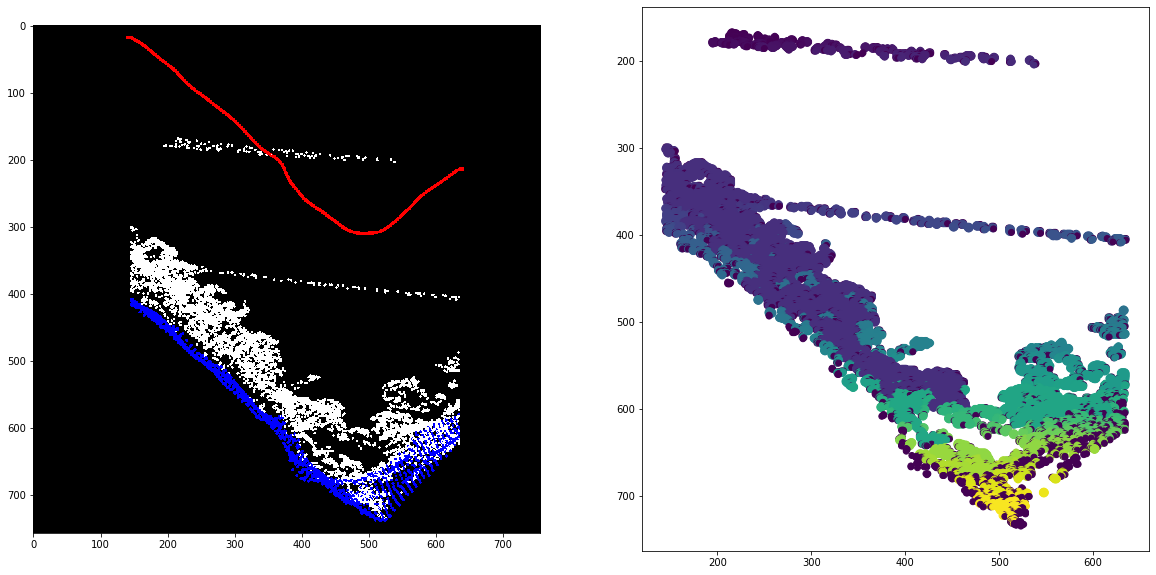

In [54]:
from sklearn.cluster import DBSCAN
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(imgp)#;plt.axis('off')
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 1).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

* DBSCAN偶爾會找到一群點同一棵樹 (如上圖)
* eps設小, 用於樹群尋找, eps設大, 用來分開電纜與地表樹叢之用

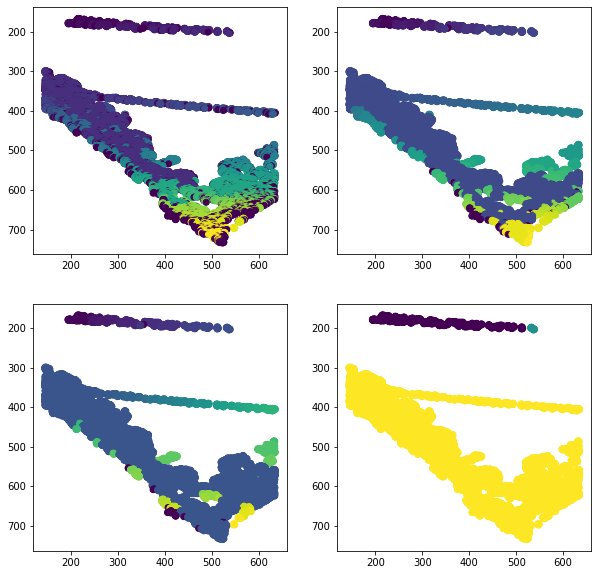

In [55]:
from sklearn.cluster import DBSCAN
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
ax = plt.gca();ax.invert_yaxis()
y_pred = DBSCAN(eps = 1).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

plt.subplot(2,2,2)
ax = plt.gca();ax.invert_yaxis()
y_pred = DBSCAN(eps = 2).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

plt.subplot(2,2,3)
ax = plt.gca();ax.invert_yaxis()
y_pred = DBSCAN(eps = 4).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

plt.subplot(2,2,4)
ax = plt.gca();ax.invert_yaxis()
y_pred = DBSCAN(eps = 16).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

In [56]:
set(y_pred)

{0, 1, 2}

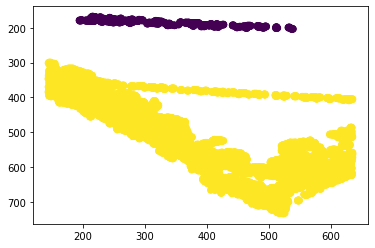

In [57]:
y_pred = DBSCAN(eps = 32).fit_predict(X)
ax = plt.gca();ax.invert_yaxis()
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

## Other Image Review: DBCAN/KMean

In [58]:
def coor(img):
    coor=[]
    for i in range(imgp.shape[0]):
        for j in range(imgp.shape[1]):
            if((imgp[i][j][0]==255) and (imgp[i][j][1]==255) and (imgp[i][j][2]==255)):
                coor.append([j,i])
    return(np.array(coor))

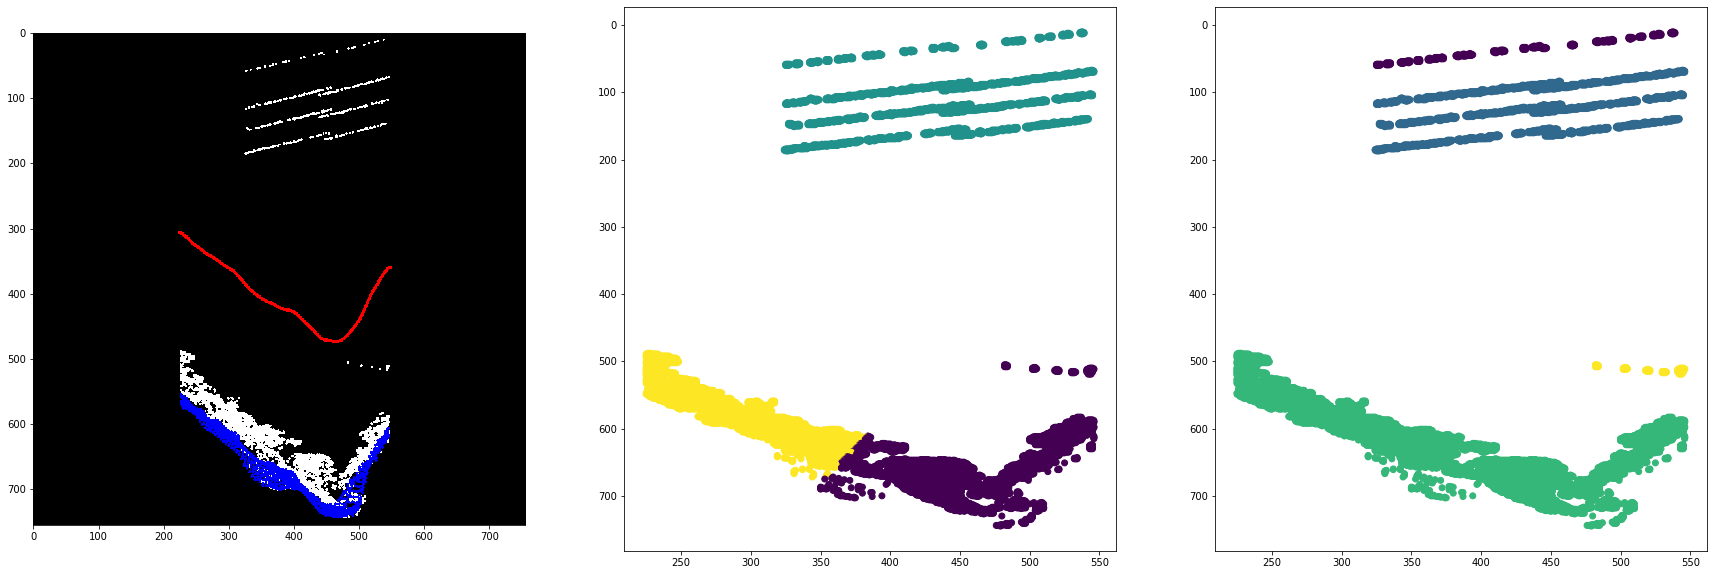

In [59]:
file='9520-1-054_256.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(imgp)
plt.subplot(1,3,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.subplot(1,3,3)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 32).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

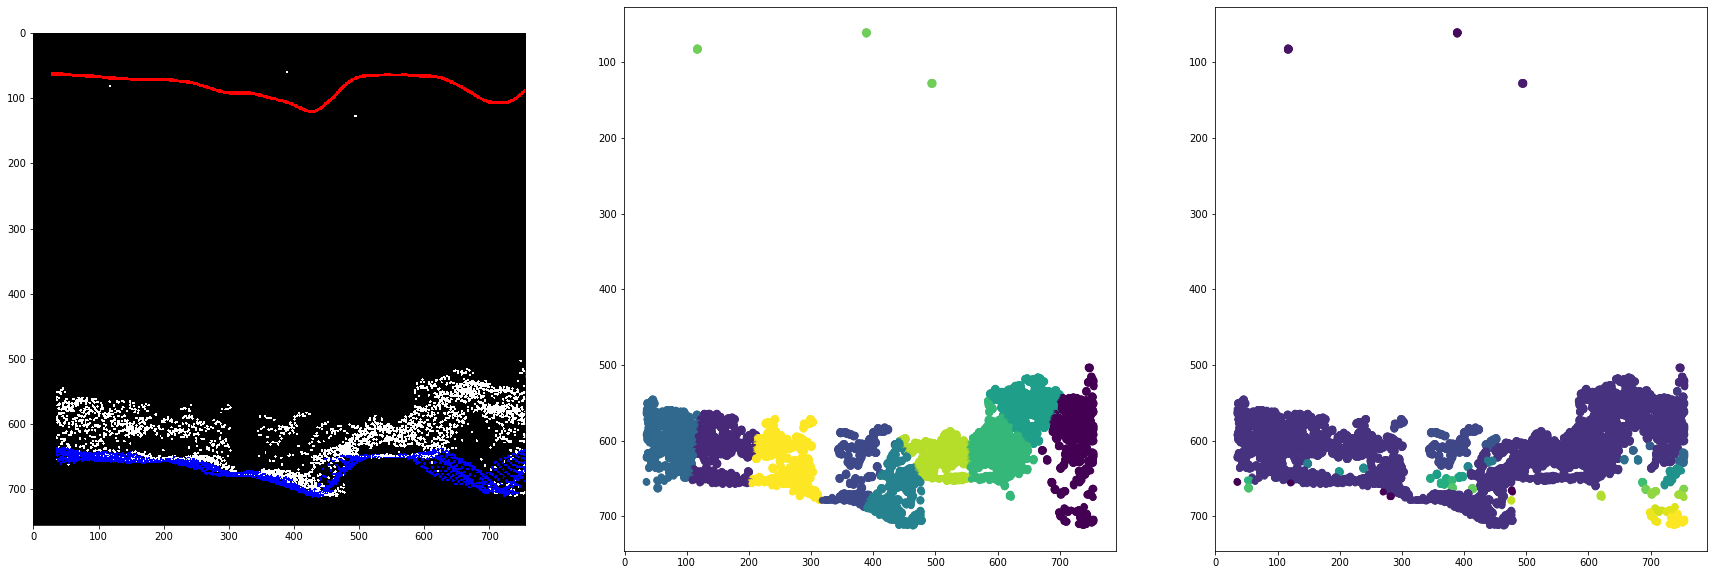

In [60]:
file='9418-1-035_001.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(imgp)
plt.subplot(1,3,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = KMeans(n_clusters=10, random_state=9).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.subplot(1,3,3)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 6).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

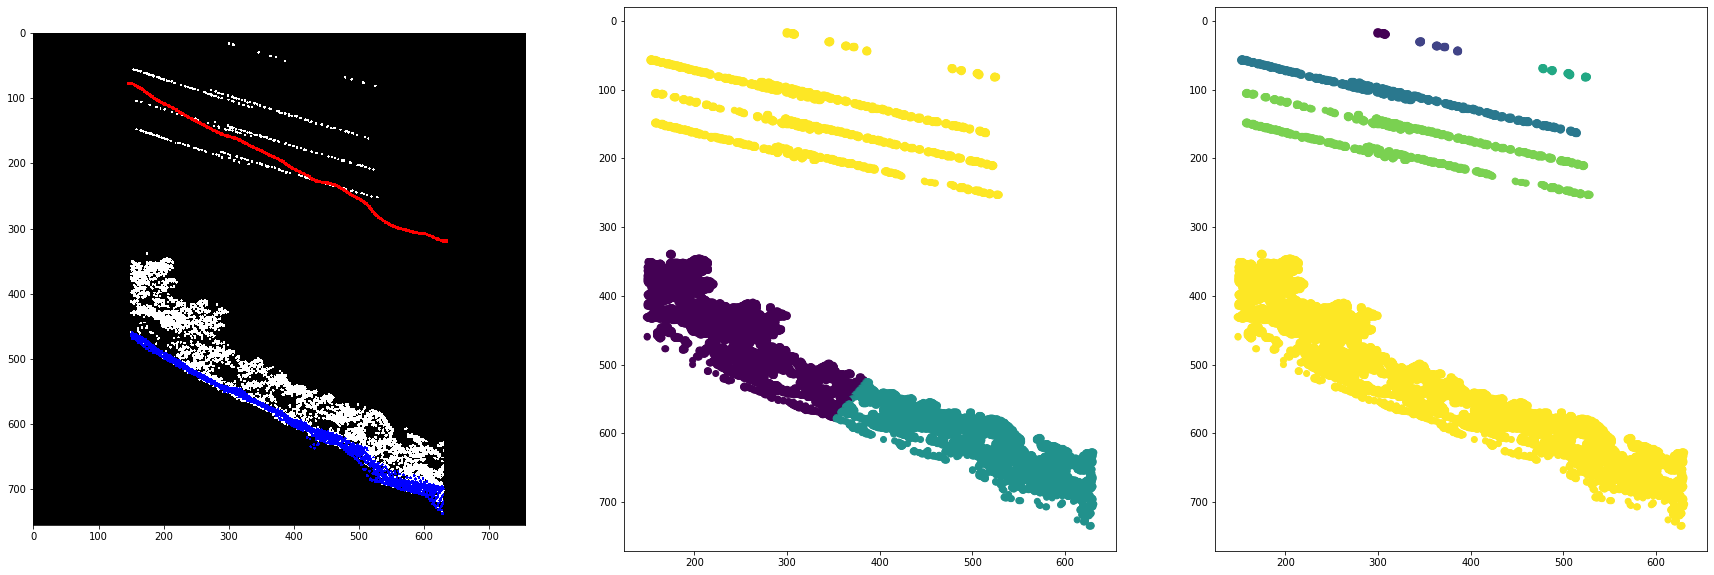

In [61]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(imgp)
plt.subplot(1,3,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.subplot(1,3,3)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 32).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

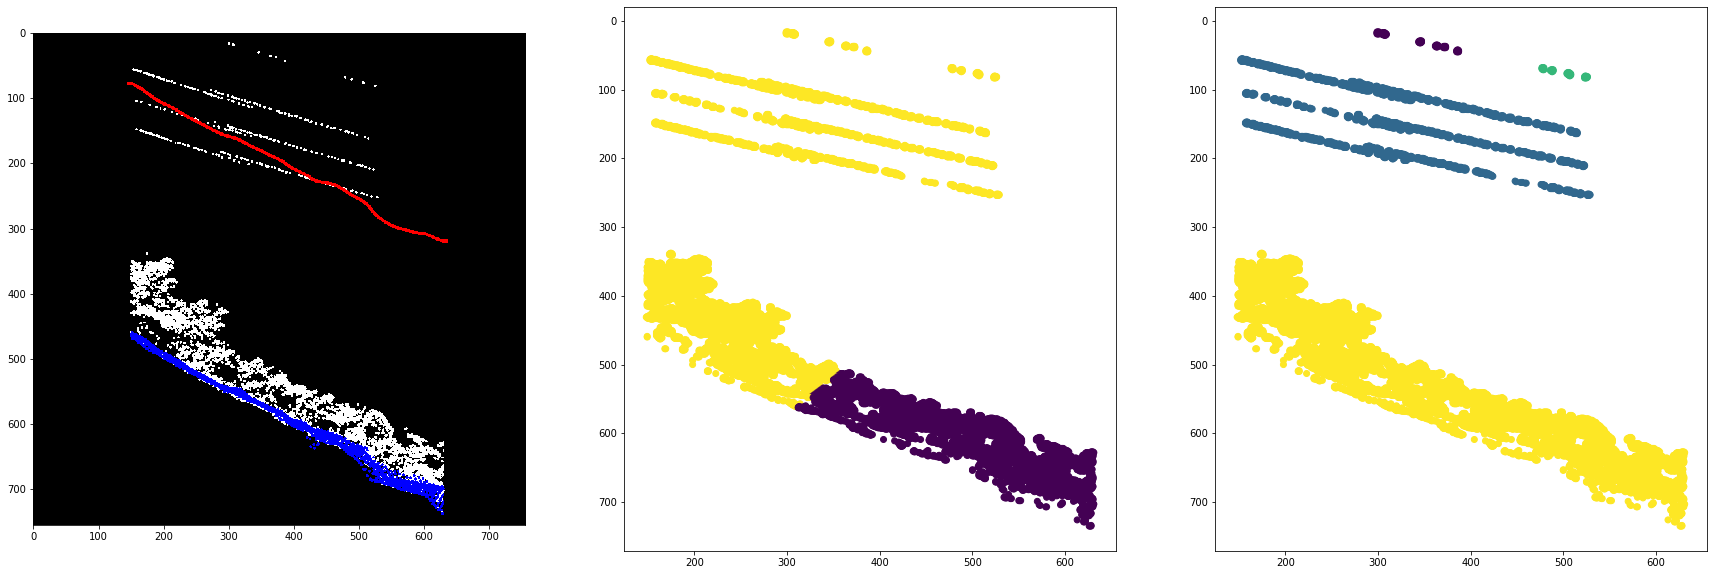

In [62]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(imgp)
plt.subplot(1,3,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = KMeans(n_clusters=2, random_state=9).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.subplot(1,3,3)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)

## Cluster Conclusion
* DBCAN 無法控制分群數, 上方電線可能會被分作多組以上
* K-Mean中k=2, 電線容易跟地表樹叢混在一群. K要設定>3
* 電纜與地表過近, 不管什麼方法, 都有可能會被分成一群
* DBSCAN偶爾會找到一群點同一棵樹 (如上圖)
* eps設小, 用於樹群尋找, eps設大, 用來分開電纜與地表樹叢之用

# 4. Hough transform Test

In [63]:
def white(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if((img[i][j][0]!=255) or (img[i][j][1]!=255) or (img[i][j][2]!=255)):
                img[i][j][0]=0;img[i][j][1]=0;img[i][j][2]=0
    return img

(503, 4)


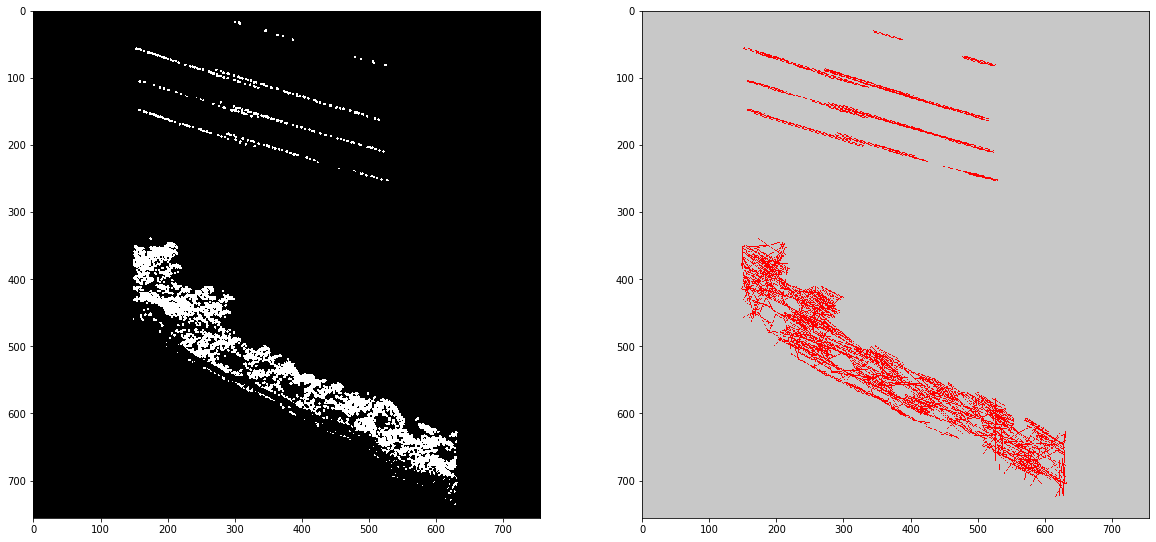

In [181]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[:,:,(2, 1, 0)]
imgp=img_pre(img0)
imgp=white(imgp)

gray = cv2.cvtColor(imgp,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,50,200)

#hough transform
rho = 1
theta = np.pi/180
threshold = 10
min_line_length = 20
max_line_gap = 15
lines = cv2.HoughLinesP(edges, rho, theta, threshold, 
                        np.array([]),min_line_length, max_line_gap)

#lines = cv2.HoughLines(edges,1,np.pi/180,160)
lines1 = lines[:,0,:]#提取為為二維
# 建立一張 512x512 的 RGB 圖片（黑色）
img = np.zeros((756, 756, 3), np.uint8)
# 將圖片用淺灰色 (200, 200, 200) 填滿
img.fill(200)
# 畫線
for x1,y1,x2,y2 in lines1[:]: 
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(imgp)
plt.subplot(122)   
plt.imshow(img)

print(lines1.shape)

(55, 4)


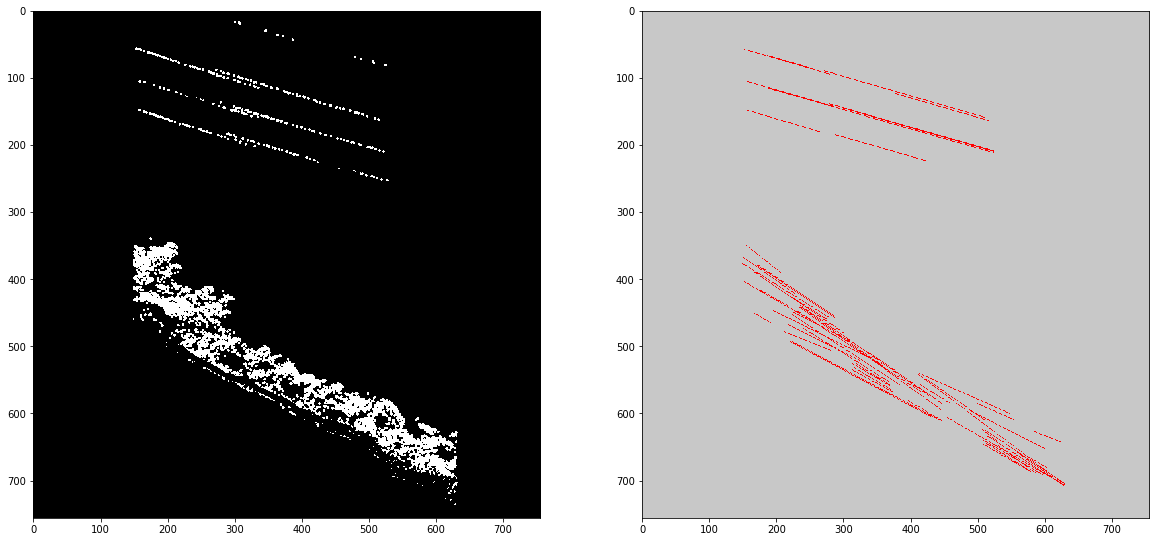

In [180]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[:,:,(2, 1, 0)]
imgp=img_pre(img0)
imgp=white(imgp)

gray = cv2.cvtColor(imgp,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,50,200)

#hough transform
rho = 1
theta = np.pi/180
threshold = 100
min_line_length = 20
max_line_gap = 15
lines = cv2.HoughLinesP(edges, rho, theta, threshold, 
                        np.array([]),min_line_length, max_line_gap)

#lines = cv2.HoughLines(edges,1,np.pi/180,160)
lines1 = lines[:,0,:]#提取為為二維
# 建立一張 512x512 的 RGB 圖片（黑色）
img = np.zeros((756, 756, 3), np.uint8)
# 將圖片用淺灰色 (200, 200, 200) 填滿
img.fill(200)
# 畫線
for x1,y1,x2,y2 in lines1[:]: 
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(imgp)
plt.subplot(122)   
plt.imshow(img)

print(lines1.shape)

(28, 4)


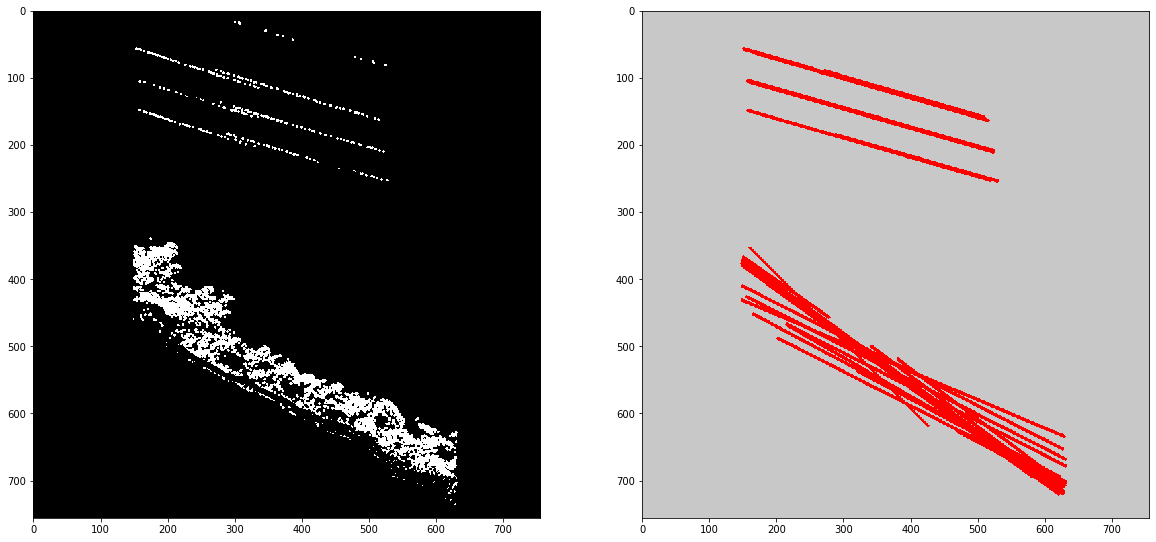

In [193]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[:,:,(2, 1, 0)]
imgp=img_pre(img0)
imgp=white(imgp)

gray = cv2.cvtColor(imgp,cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray,50,200)

#hough transform
rho = 1 # 半徑的分辨率
theta = np.pi/180 # 角度分辨率
threshold = 100 # 判斷直線點數的閾值
min_line_length = 40 # 線段長度閾值
max_line_gap = 40 # 線段上最近兩點之間的閾值
lines = cv2.HoughLinesP(edges, rho, theta, threshold, 
                        np.array([]),min_line_length, max_line_gap)

#lines = cv2.HoughLines(edges,1,np.pi/180,160)
lines1 = lines[:,0,:]#提取為為二維
# 建立一張 512x512 的 RGB 圖片（黑色）
img = np.zeros((756, 756, 3), np.uint8)
# 將圖片用淺灰色 (200, 200, 200) 填滿
img.fill(200)
# 畫線
for x1,y1,x2,y2 in lines1[:]: 
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),3)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(imgp)
plt.subplot(122)   
plt.imshow(img)

print(lines1.shape)

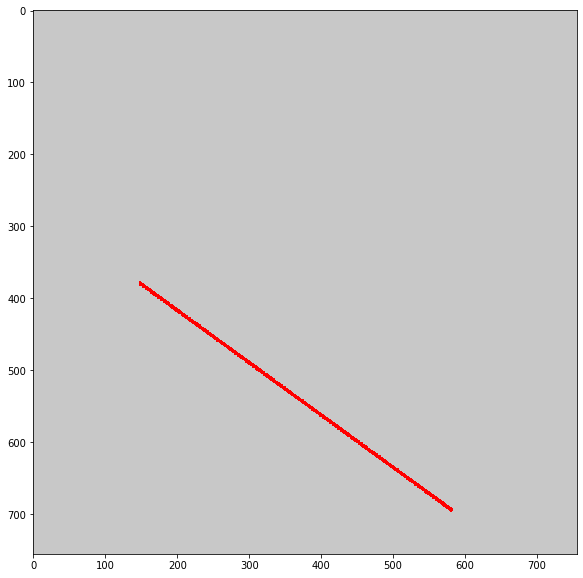

In [196]:
x1,y1,x2,y2 = lines1[2]
img = np.zeros((756, 756, 3), np.uint8)
img.fill(200)
cv2.line(img,(x1,y1),(x2,y2),(255,0,0),3)
plt.figure(figsize=(20,10));plt.imshow(img)

# DBSCAN + R-Square
測試: 群找DBSCAN各群的線性回歸RMSE, 期望找出地表(RMSE最大, 數量最多)與電纜(RMSE最小)
## 結論
地表RMSE不一定最大 (如果天空電纜分群不好), 電纜可能將2條直線分群再一起, 造成RMSE增加

In [197]:
from sklearn.metrics import r2_score

{0, 1, 2, 3, 4, 5}


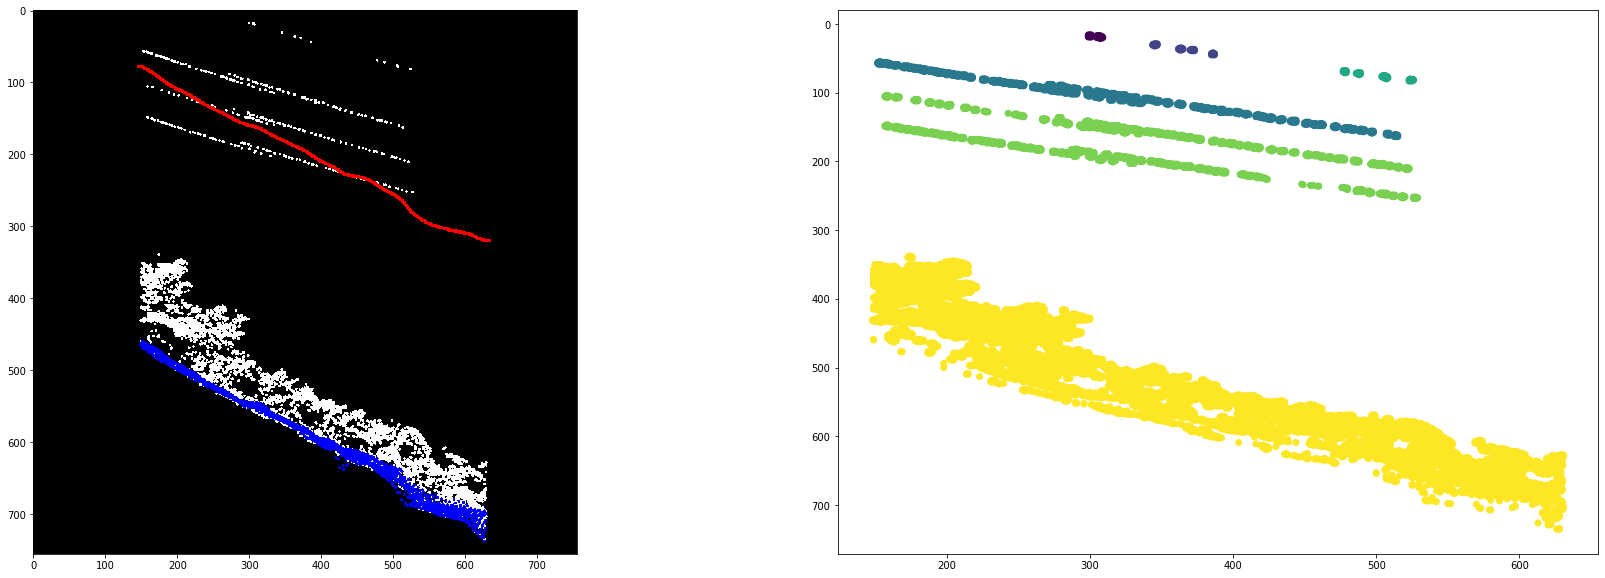

In [202]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 32).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

In [291]:
L_RMSE=[];LC=[]
for i in set(y_pred):
    Lx=[];Ly=[];count=0
    for j in range(y_pred.shape[0]):
        if(y_pred[j]==i):
            Lx.append(X[j][0]);Ly.append(X[j][1])
            count+=1
    xa=np.array(Lx);ya=np.array(Ly)
    xa=np.reshape(xa,(len(xa),1));ya=np.reshape(ya,(len(ya),1))
    lm = LinearRegression();lm.fit(xa,ya)
    mse=np.mean((lm.predict(xa)-ya)**2)
    rmse = (mse)**0.5
    L_RMSE.append(rmse)
    LC.append(count)
    print(xa.shape[0],rmse)

31 1.157689504832577
45 1.105504761277244
1040 2.3679456697403647
53 1.1128124481487505
1609 21.243213742790385
21834 29.238288189594307


In [259]:
L_RMSE

[1.157689504832577,
 1.105504761277244,
 2.3679456697403647,
 1.1128124481487505,
 21.243213742790385,
 29.238288189594307]

RMSE=  29.238288189594307 Count=  21834


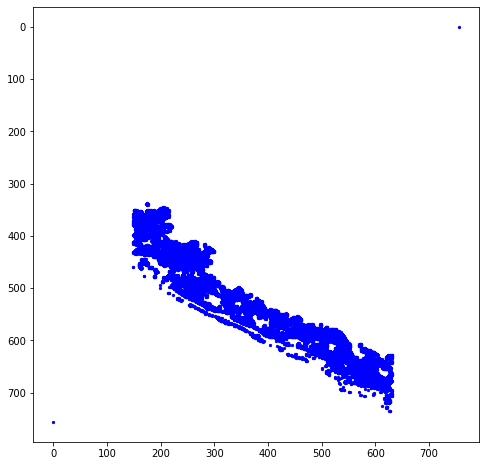

In [295]:
Lx=[];Ly=[];n=5
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

RMSE=  21.243213742790385 Count=  1609


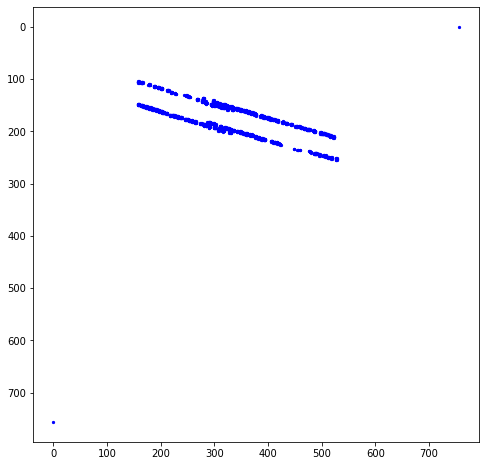

In [296]:
Lx=[];Ly=[];n=4
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

RMSE=  1.1128124481487505 Count=  53


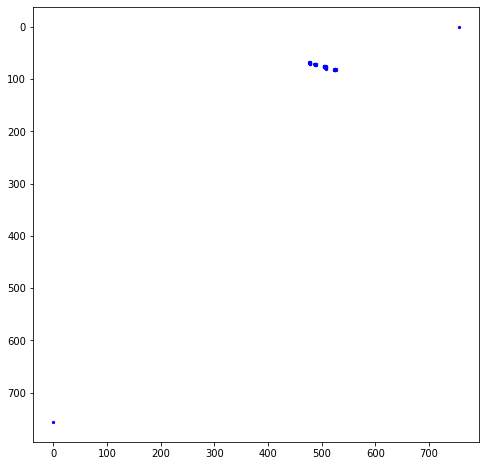

In [297]:
Lx=[];Ly=[];n=3
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

RMSE=  2.3679456697403647 Count=  1040


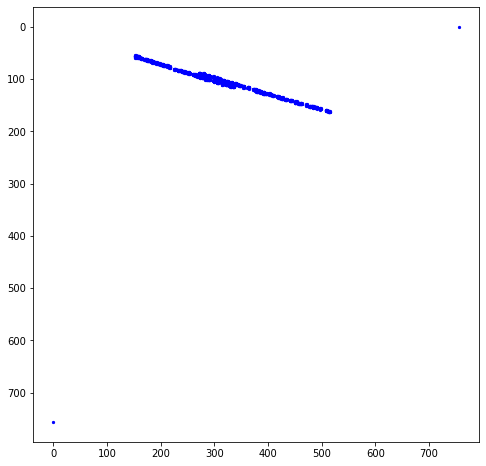

In [298]:
Lx=[];Ly=[];n=2
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

RMSE=  1.105504761277244 Count=  45


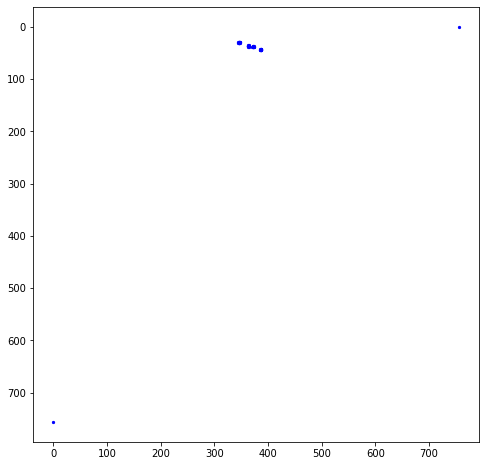

In [299]:
Lx=[];Ly=[];n=1
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

RMSE=  1.157689504832577 Count=  31


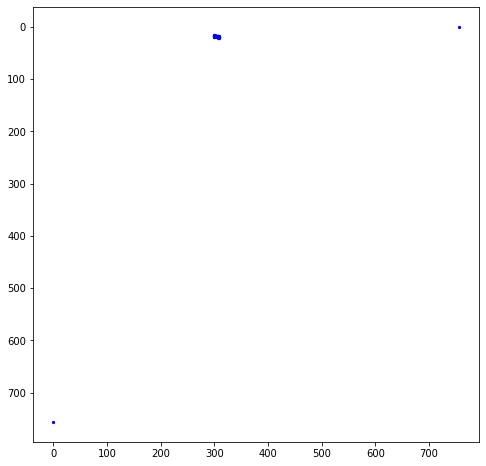

In [300]:
Lx=[];Ly=[];n=0
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

## 縮小 eps 測試
地表獨立點出線. 電纜不連續情況增加.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1}


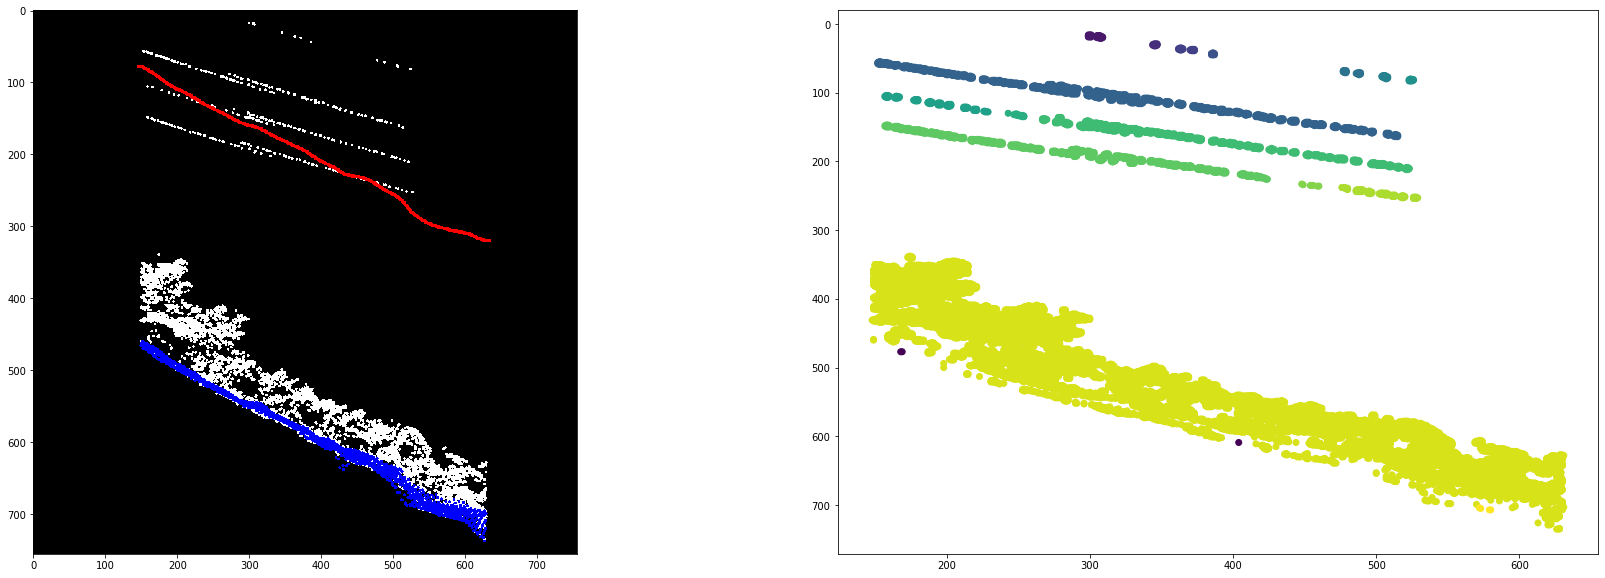

In [301]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 12).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

## 增加 eps 測試
地表統一. 不同電纜線被分成同一群

{0, 1, 2, 3}


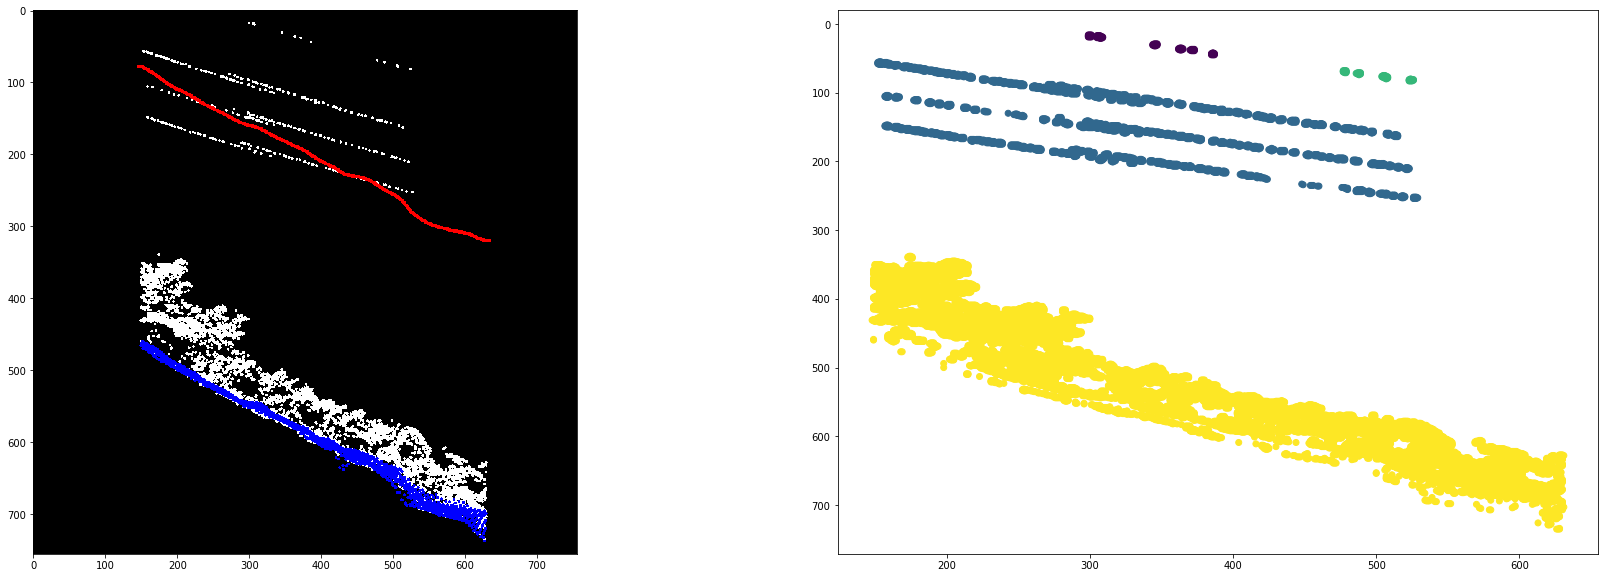

In [302]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

### 增加EPS看起來可以有效將地表與電纜分成2群, 但是電纜RMSE居然比地表高

In [303]:
L_RMSE=[];LC=[]
for i in set(y_pred):
    Lx=[];Ly=[];count=0
    for j in range(y_pred.shape[0]):
        if(y_pred[j]==i):
            Lx.append(X[j][0]);Ly.append(X[j][1])
            count+=1
    xa=np.array(Lx);ya=np.array(Ly)
    xa=np.reshape(xa,(len(xa),1));ya=np.reshape(ya,(len(ya),1))
    lm = LinearRegression();lm.fit(xa,ya)
    mse=np.mean((lm.predict(xa)-ya)**2)
    rmse = (mse)**0.5
    L_RMSE.append(rmse)
    LC.append(count)
    print(xa.shape[0],rmse)

76 1.1690828731291767
2649 37.34764691015677
53 1.1128124481487505
21834 29.238288189594307


RMSE=  29.238288189594307 Count=  21834


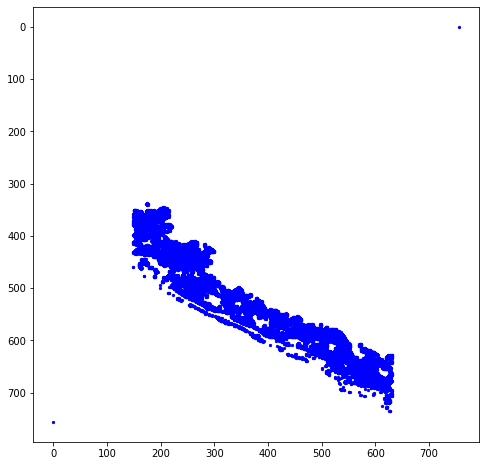

In [304]:
Lx=[];Ly=[];n=3
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

RMSE=  1.1128124481487505 Count=  53


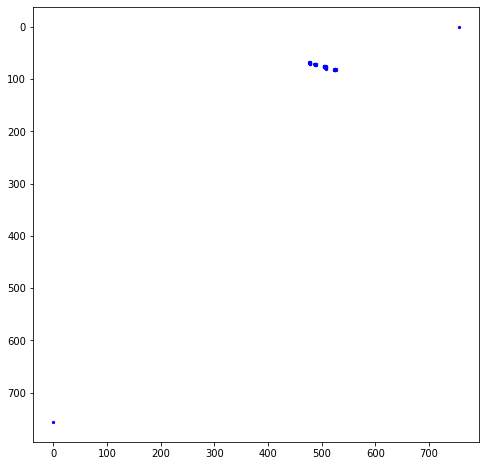

In [305]:
Lx=[];Ly=[];n=2
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

RMSE=  37.34764691015677 Count=  2649


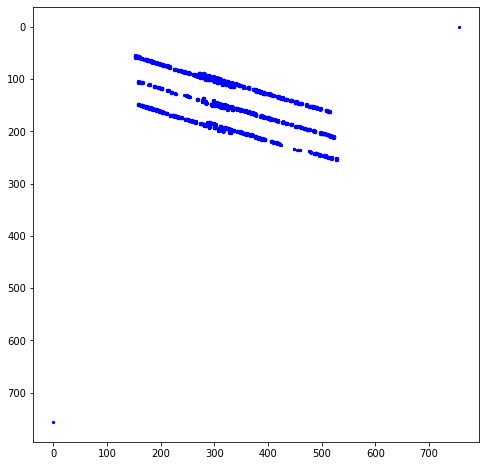

In [306]:
Lx=[];Ly=[];n=1
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

RMSE=  1.1690828731291767 Count=  76


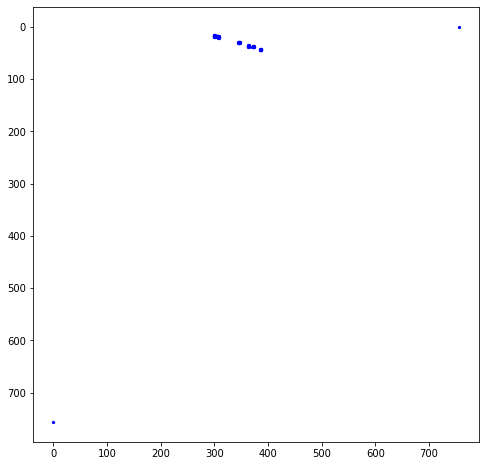

In [307]:
Lx=[];Ly=[];n=0
for j in range(y_pred.shape[0]):
    if(y_pred[j]==n):
        Lx.append(X[j][0]);Ly.append(X[j][1])
Lx.append(0);Ly.append(756)
Lx.append(756);Ly.append(0)
plt.figure(figsize=(8,8))
ax = plt.gca();ax.invert_yaxis()
plt.scatter(Lx,Ly, s=5, c='blue')
print('RMSE= ',L_RMSE[n],'Count= ',LC[n])

# 測試: 2階段DBSCAN, 第1階段使用較大的eps, 過濾地表(最多次數的那一群), 第2階段在針對剩餘群組(電纜)做分群(使用較小的eps)

{0, 1, 2, 3}


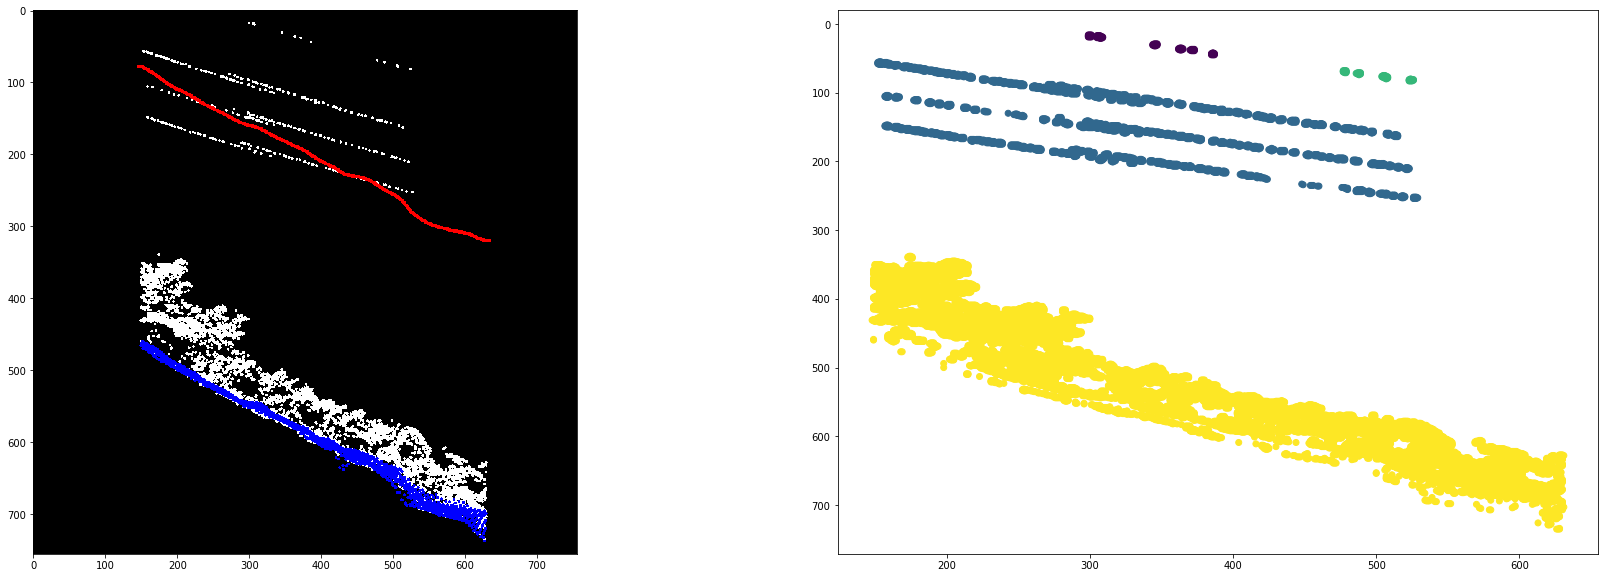

In [337]:
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

In [338]:
L_RMSE=[];LC=[]
for i in set(y_pred):
    Lx=[];Ly=[];count=0
    for j in range(y_pred.shape[0]):
        if(y_pred[j]==i):
            Lx.append(X[j][0]);Ly.append(X[j][1])
            count+=1
    xa=np.array(Lx);ya=np.array(Ly)
    xa=np.reshape(xa,(len(xa),1));ya=np.reshape(ya,(len(ya),1))
    lm = LinearRegression();lm.fit(xa,ya)
    mse=np.mean((lm.predict(xa)-ya)**2)
    rmse = (mse)**0.5
    L_RMSE.append(rmse)
    LC.append(count)
    print(xa.shape[0],rmse)

76 1.1690828731291767
2649 37.34764691015677
53 1.1128124481487505
21834 29.238288189594307


In [343]:
print(y_pred.shape,X.shape)

(24612,) (24612, 2)


### 取除地表座標

In [346]:
y_pred_new_L=[];X_new_L=[]
for i in range(y_pred.shape[0]):
    if(y_pred[i]!=LC.index(max(LC))):
        y_pred_new_L.append(y_pred[i])
        X_new_L.append(X[i])
y_pred_new=np.array(y_pred_new_L)
X_new=np.array(X_new_L)
print(y_pred_new.shape,X_new.shape)

(2778,) (2778, 2)


### 2nd DBSCAN

{0, 1, 2, 3, 4, 5}


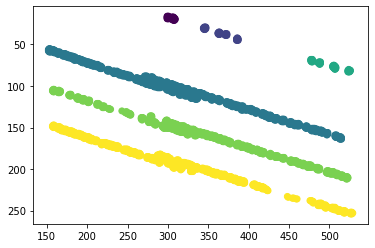

In [356]:
ax = plt.gca() 
ax.invert_yaxis()
y_pred2 = DBSCAN(eps = 30).fit_predict(X_new)
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_pred2)
print(set(y_pred2))

In [362]:
L_RMSE=[];LC=[]
for i in set(y_pred2):
    Lx=[];Ly=[];count=0
    for j in range(y_pred2.shape[0]):
        if(y_pred2[j]==i):
            Lx.append(X_new[j][0]);Ly.append(X_new[j][1])
            count+=1
    xa=np.array(Lx);ya=np.array(Ly)
    xa=np.reshape(xa,(len(xa),1));ya=np.reshape(ya,(len(ya),1))
    lm = LinearRegression();lm.fit(xa,ya)
    mse=np.mean((lm.predict(xa)-ya)**2)
    rmse = (mse)**0.5
    L_RMSE.append(rmse)
    LC.append(count)
    print(xa.shape[0],rmse)

31 1.157689504832577
45 1.105504761277244
1040 2.3679456697403647
53 1.1128124481487505
792 1.9885783803636041
817 2.1876897582675485


In [360]:
y_pred2+10

array([10, 10, 10, ..., 15, 15, 15], dtype=int64)

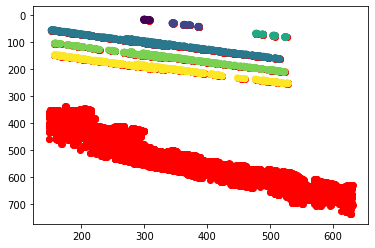

In [361]:
ax = plt.gca() 
ax.invert_yaxis()
plt.scatter(X[:, 0], X[:, 1], c="red")
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_pred2+10)

### 2nd DBSCAN test

沒有電纜/人工建築, DBSCAN只會分類成一種

{0}


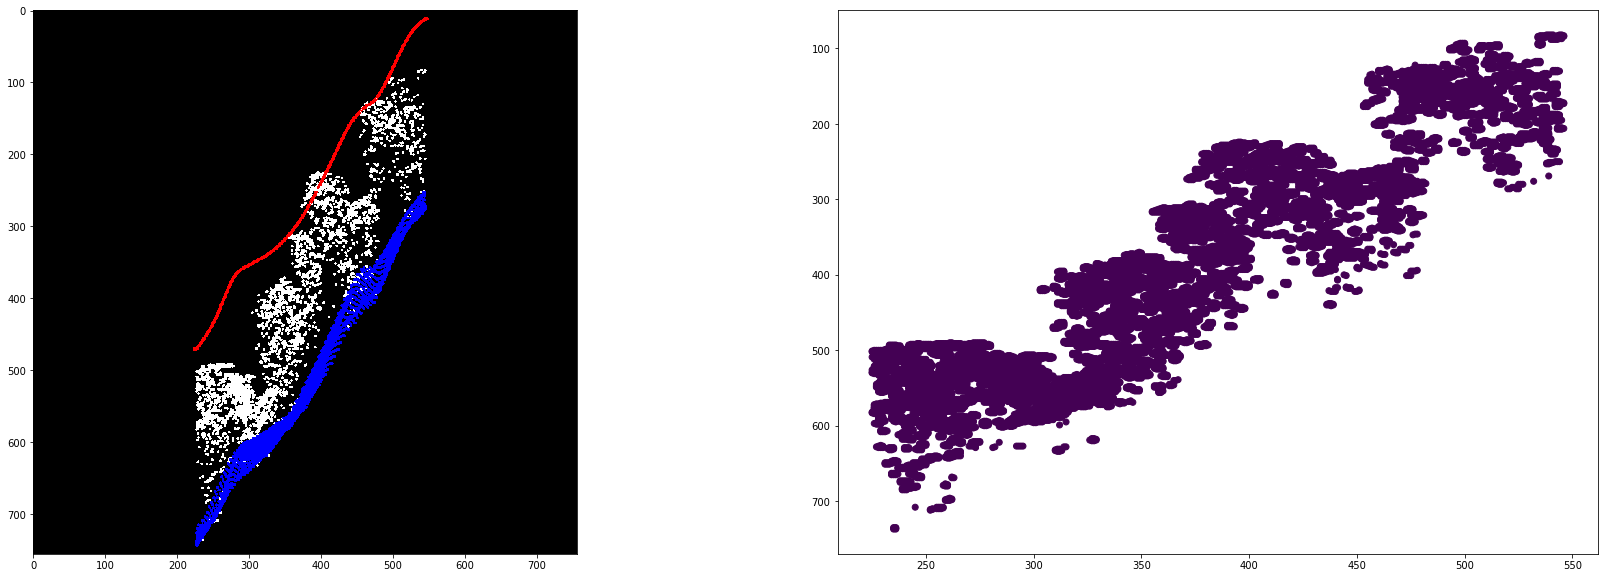

In [399]:
from sklearn.cluster import DBSCAN
file='9619-4-088_021.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1, 2, 3}


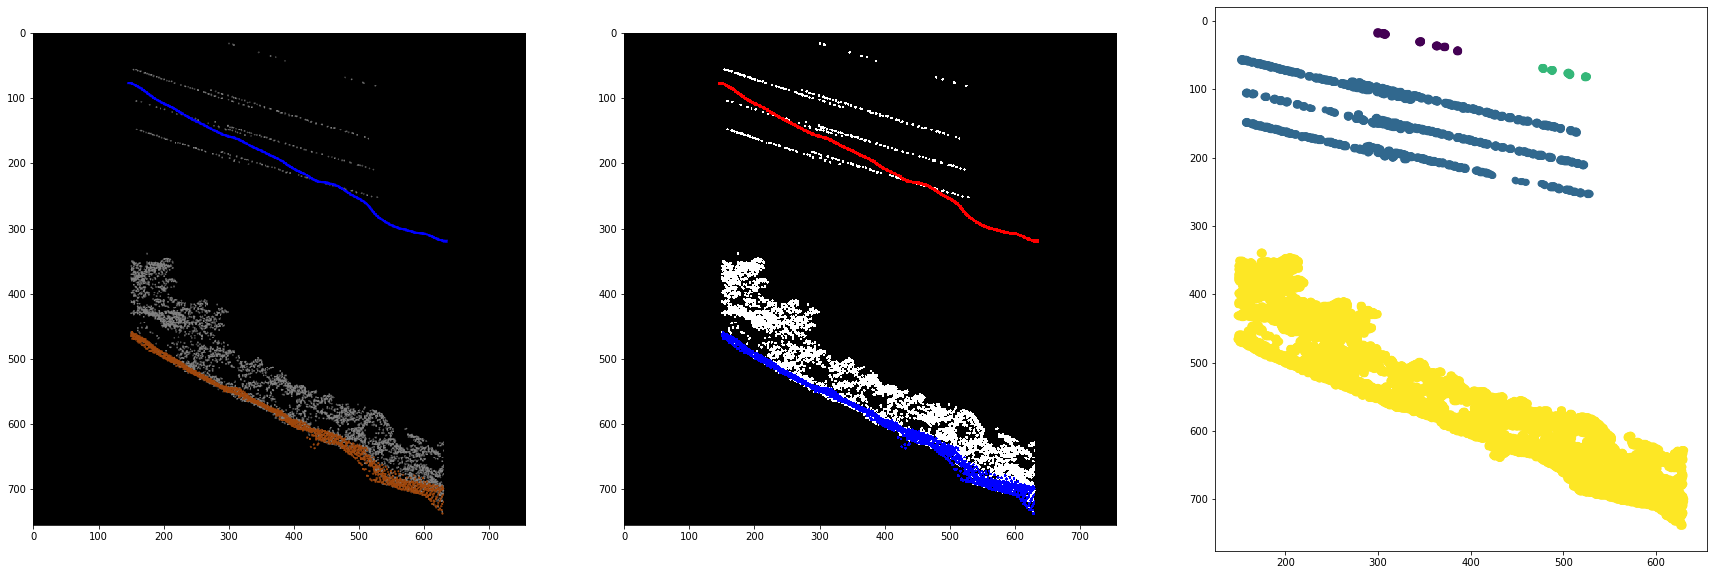

In [8]:
from sklearn.cluster import DBSCAN
file='9521-2-084_049.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(img0)
plt.subplot(1,3,2)
plt.imshow(imgp)
plt.subplot(1,3,3)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

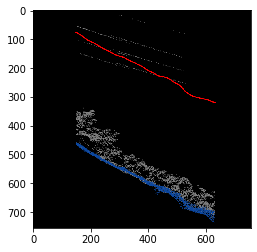

In [9]:
img0=cv2.imread(path+file)
plt.imshow(img0)

In [374]:
len(set(y_pred)) #分群種類數量

1

In [368]:
# remove coor of ground
y_pred_new_L=[];X_new_L=[]
for i in range(y_pred.shape[0]):
    if(y_pred[i]!=LC.index(max(LC))):
        y_pred_new_L.append(y_pred[i])
        X_new_L.append(X[i])
y_pred_new=np.array(y_pred_new_L)
X_new=np.array(X_new_L)

移除地表座標之後, 剩下空值

In [371]:
X_new

array([], dtype=float64)

DBSCAN會產生error

In [372]:
# 2nd DBSCAN
y_pred2 = DBSCAN(eps = 30).fit_predict(X_new)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# 測試 全部圖跑DBSCAN, eps = 64, 計算分群種類數量

In [402]:
file='9619-4-088_021.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
y_pred = DBSCAN(eps = 64).fit_predict(X)
print(len(set(y_pred)))

1


In [4]:
df = pd.read_csv("./liddar_img_v1.csv")
df.head(3)

id  area               image  valid_count  valid_count_zero  is_finished  \
0  3094     1  9621-1-006_001.png            1                 3            1   
1  1427     1  9621-1-006_002.png            0                 3            1   
2  4814     1  9621-1-006_003.png            3                 2            1   

           update_t  
0  2020/12/23 12:21  
1  2020/12/23 12:21  
2  2020/12/23 12:21

In [385]:
df.shape

(54415, 8)

In [403]:
df['image'][0]

'9721-4-059_026.png'

In [433]:
DList=[]
for i in range(df.shape[0]):
    file=df['image'][i]
    img0=cv2.imread(path+file)
    img0 = img0[ : , : , (2, 1, 0)]
    imgp=img_pre(img0)
    X=coor(imgp)
    y_pred = DBSCAN(eps = 64).fit_predict(X)
    result=len(set(y_pred))
    DList.append(result)
    print(i,file,result)

0 9621-1-006_001.png 1
1 9621-1-006_002.png 1
2 9621-1-006_003.png 1
3 9621-1-006_004.png 1
4 9621-1-006_005.png 1
5 9621-1-006_006.png 1
6 9621-1-006_007.png 1
7 9621-1-006_008.png 1
8 9621-1-006_010.png 1
9 9621-1-006_011.png 1
10 9621-1-006_012.png 1
11 9621-1-006_013.png 1
12 9621-1-006_014.png 1
13 9621-1-006_015.png 1
14 9621-1-006_017.png 1
15 9621-1-006_018.png 2


KeyboardInterrupt: 

In [4]:
def coor(imgp):
    coor=[]
    for i in range(imgp.shape[0]):
        for j in range(imgp.shape[1]):
            if((imgp[i][j][0]==255) and (imgp[i][j][1]==255) and (imgp[i][j][2]==255)):
                coor.append([j,i])
            if((imgp[i][j][0]==0) and (imgp[i][j][1]==0) and (imgp[i][j][2]==255)): #保留地表基線(藍線)
                coor.append([j,i])
    return(np.array(coor))

{0}


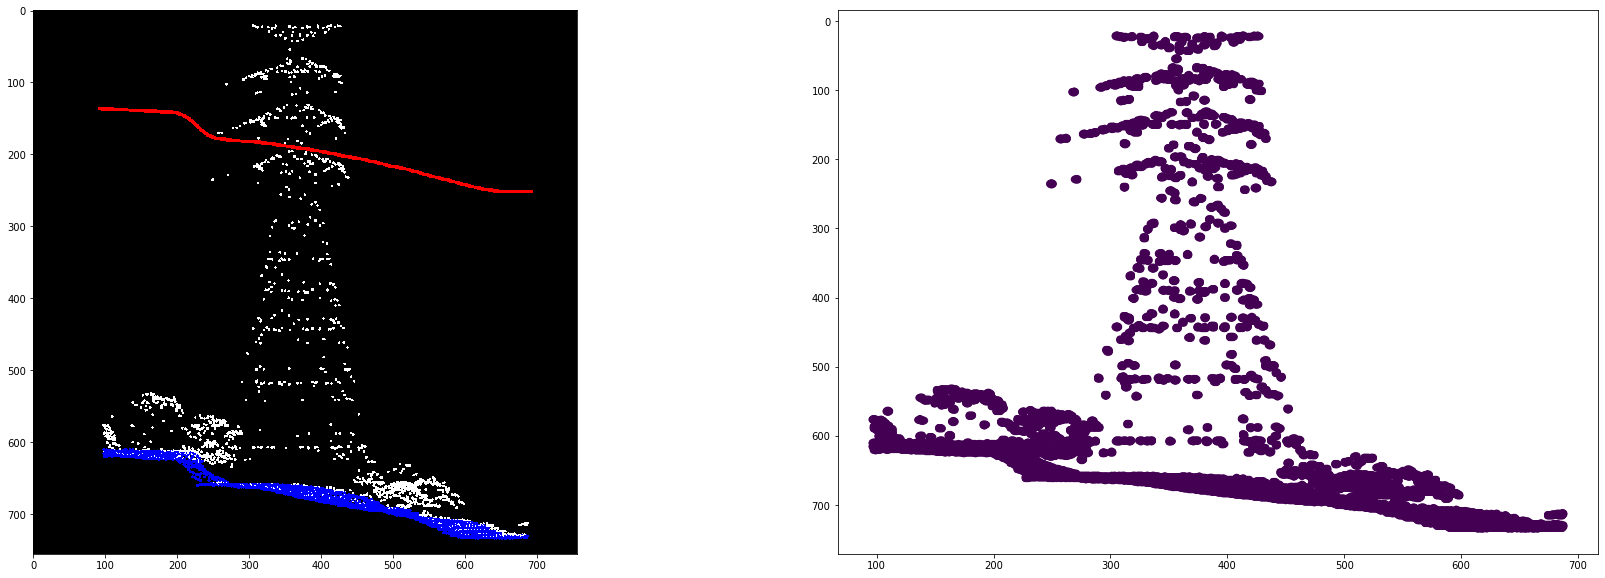

In [435]:
from sklearn.cluster import DBSCAN
file='9418-1-035_005.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0}


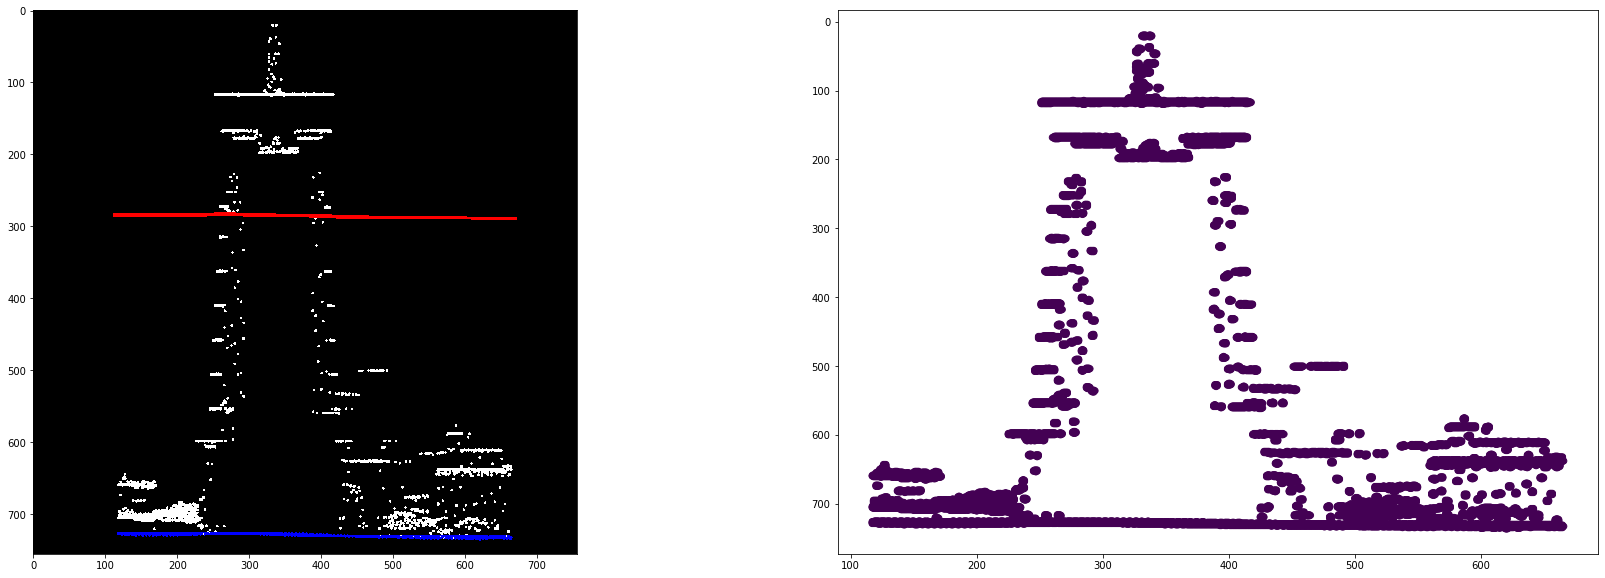

In [436]:
file='9520-1-019_001.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0}


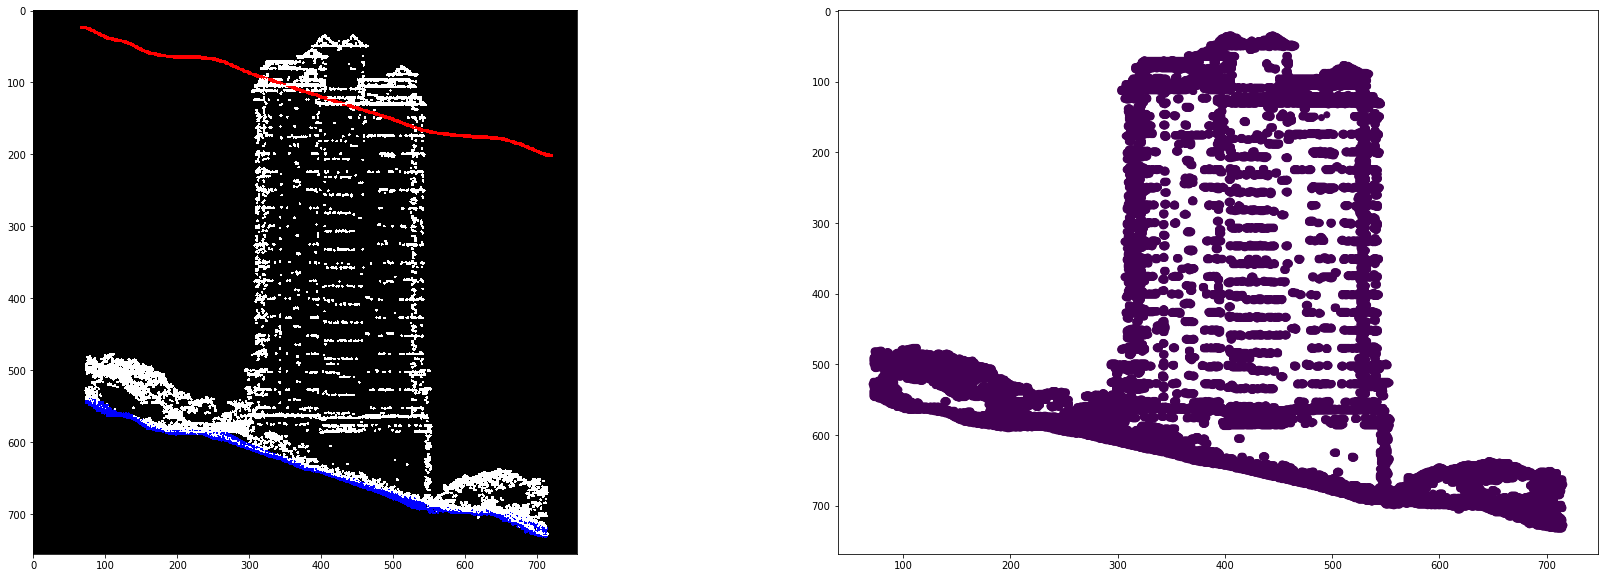

In [440]:
file='9622-1-030_004.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0}


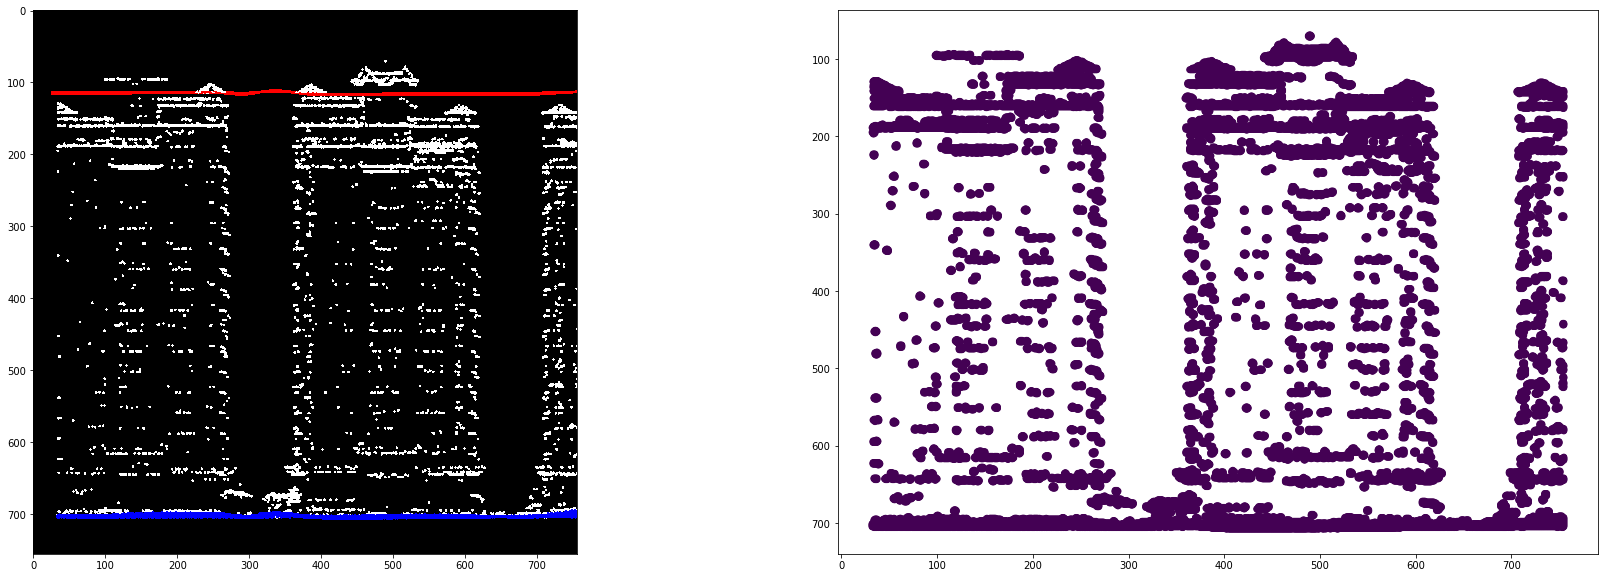

In [441]:
file='9622-1-030_021.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


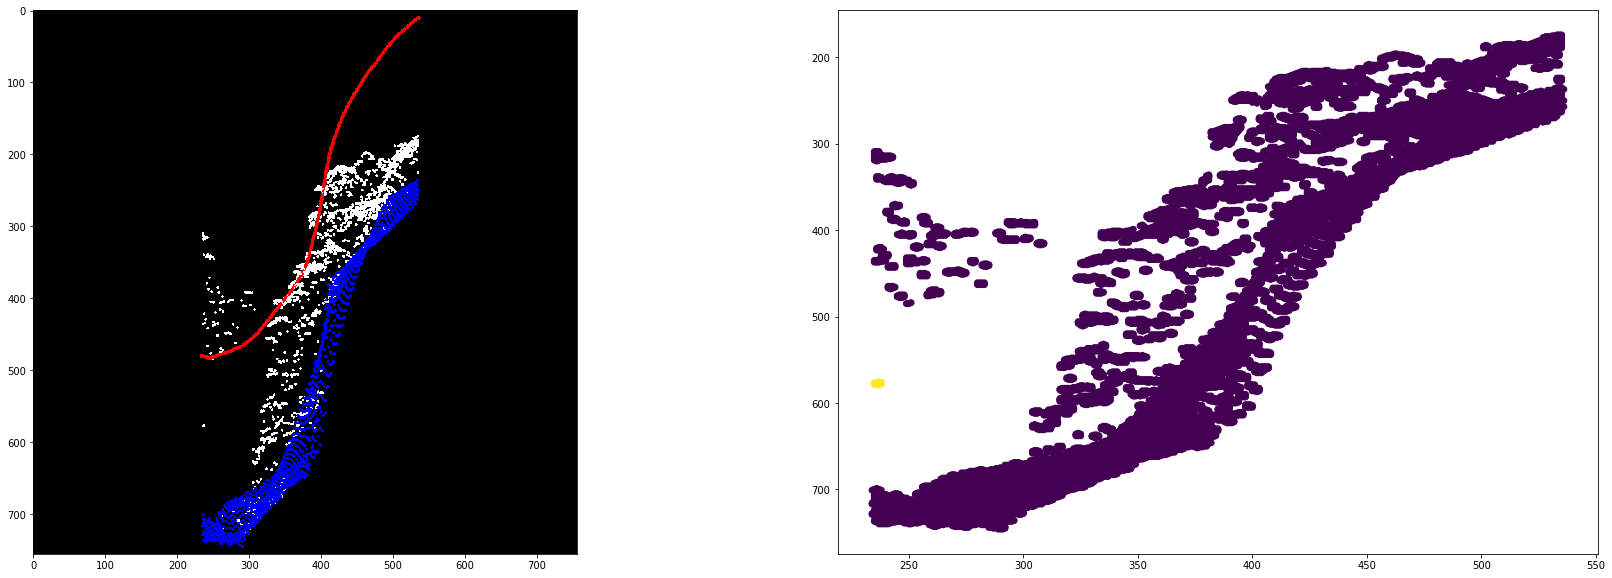

In [437]:
file='9621-1-006_052.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


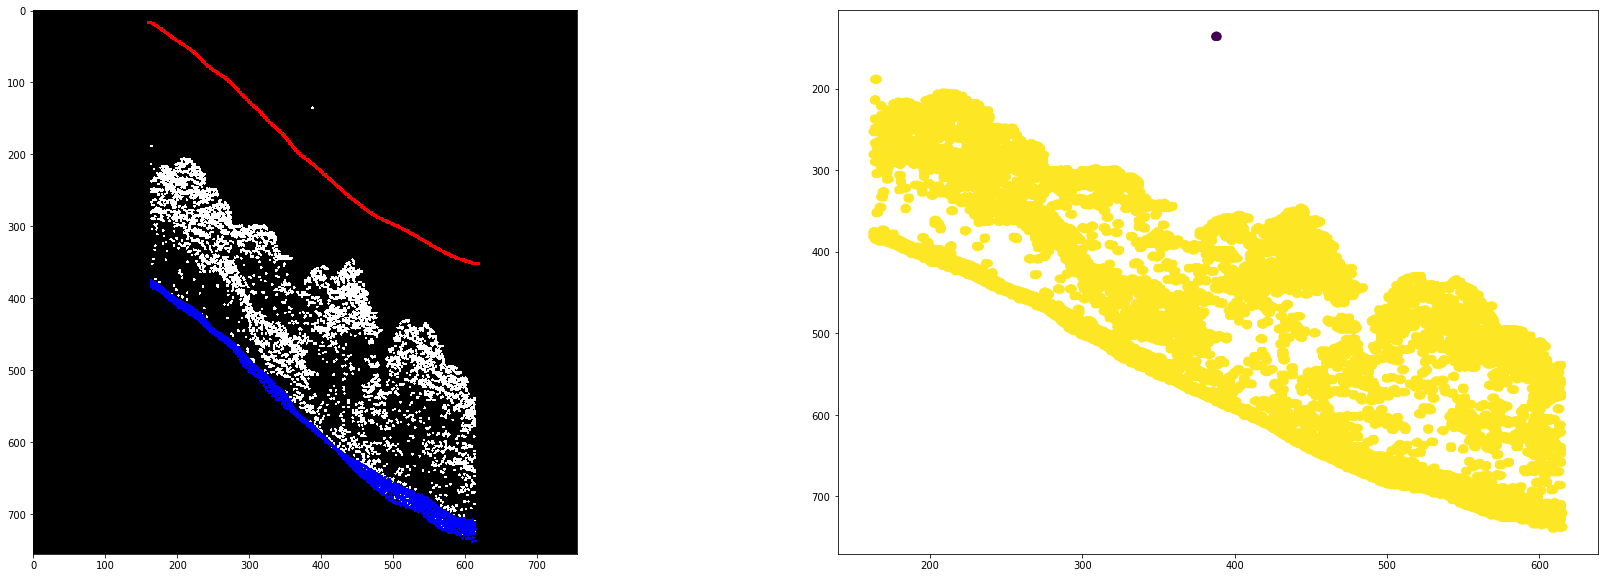

In [439]:
# 同編號其他圖都沒有這個懸空的一點, 可能是一隻鳥飛過
file='9621-1-059_003.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


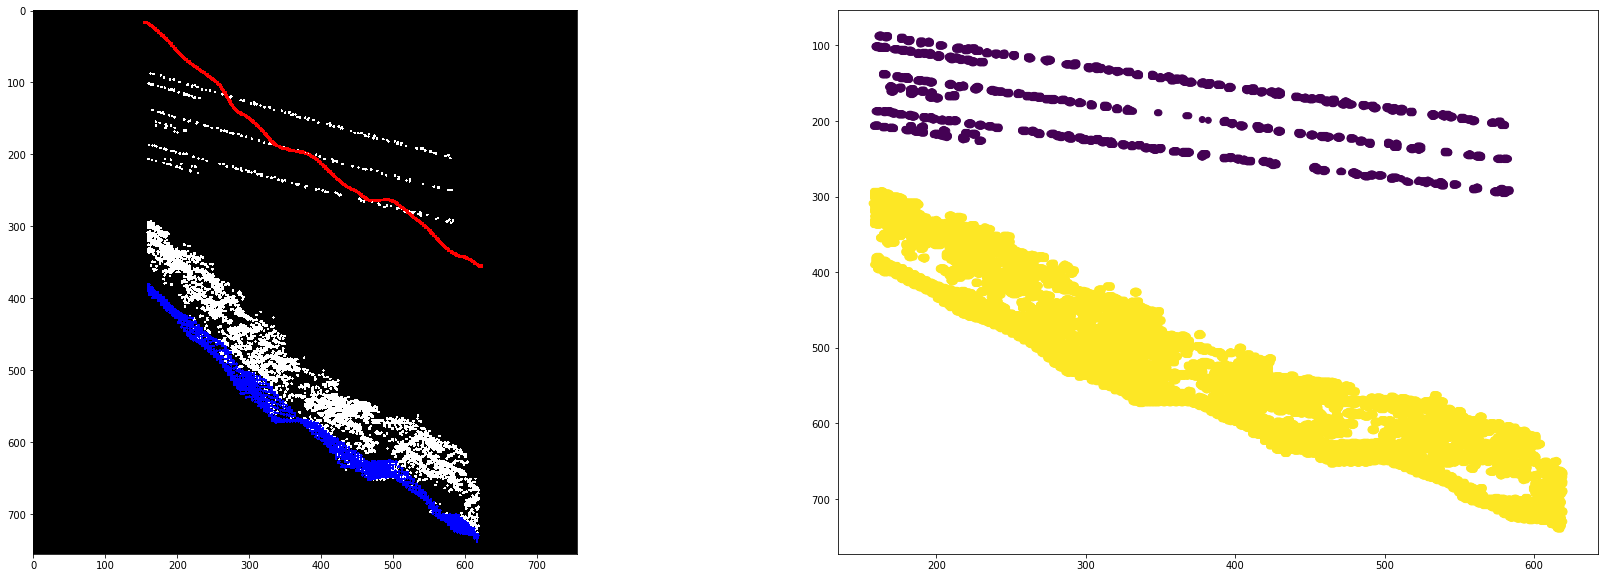

In [442]:
file='9622-1-044_037.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0}


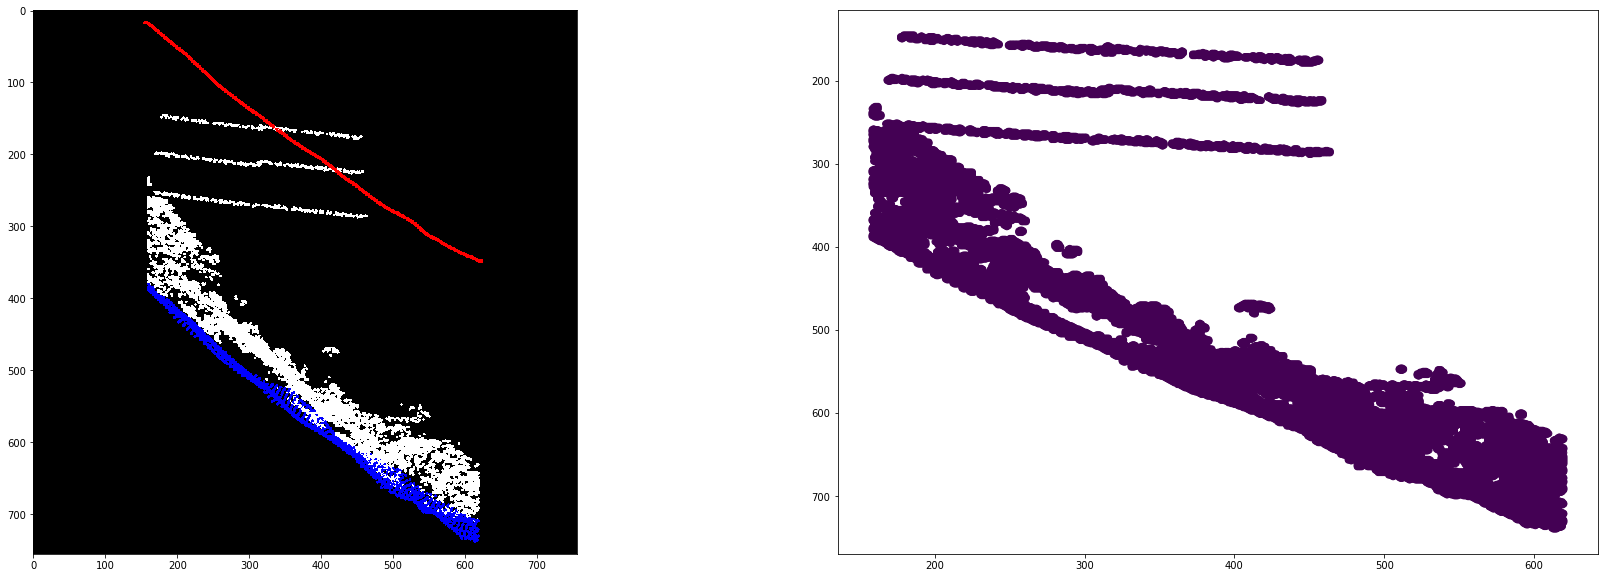

In [443]:
file='9622-1-048_087.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

### 解法一: (1) 使用eps=30, 分群電纜, (2) Min(RMSE)<1.5 : 至少有一條懸空電纜存在

{0, 1, 2}


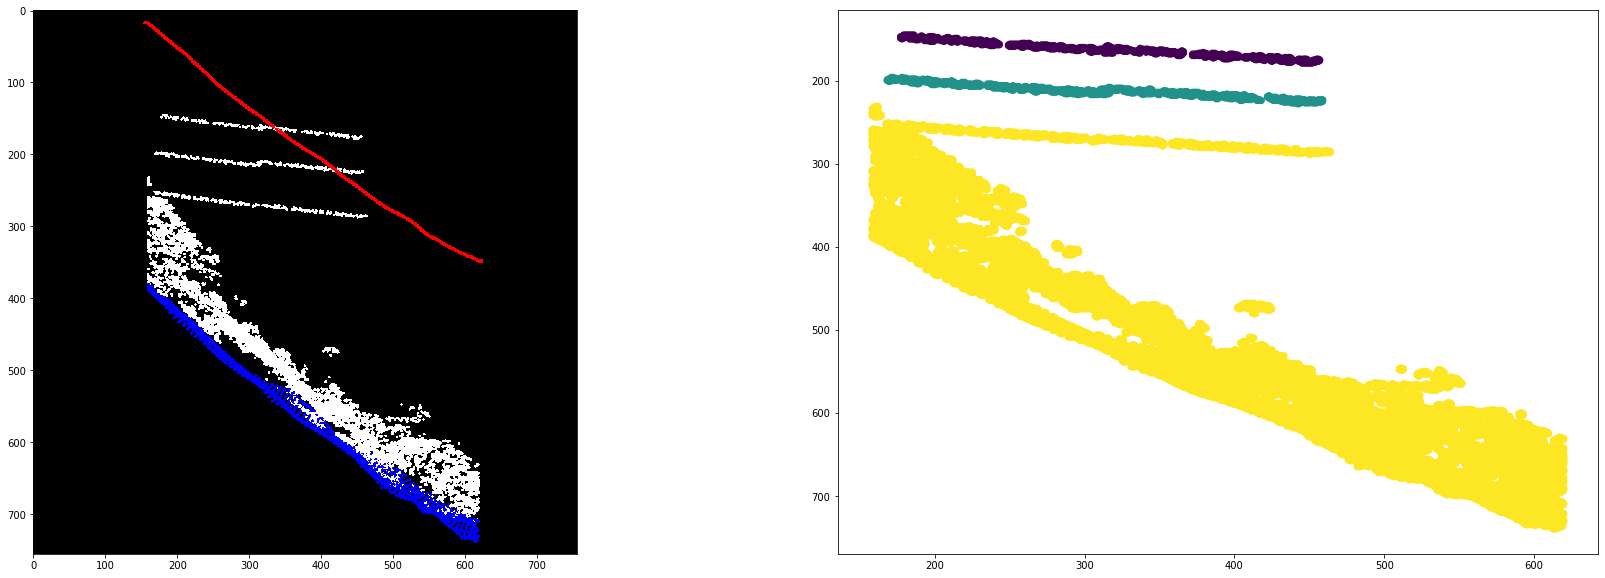

In [444]:
file='9622-1-048_087.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 30).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

In [445]:
L_RMSE=[];LC=[]
for i in set(y_pred):
    Lx=[];Ly=[];count=0
    for j in range(y_pred.shape[0]):
        if(y_pred[j]==i):
            Lx.append(X[j][0]);Ly.append(X[j][1])
            count+=1
    xa=np.array(Lx);ya=np.array(Ly)
    xa=np.reshape(xa,(len(xa),1));ya=np.reshape(ya,(len(ya),1))
    lm = LinearRegression();lm.fit(xa,ya)
    mse=np.mean((lm.predict(xa)-ya)**2)
    rmse = (mse)**0.5
    L_RMSE.append(rmse)
    LC.append(count)
    print(xa.shape[0],rmse)

1096 1.7627995067940627
1269 2.135261129026833
36960 52.76217933103451


# 以下繼續測試

{0, 1}


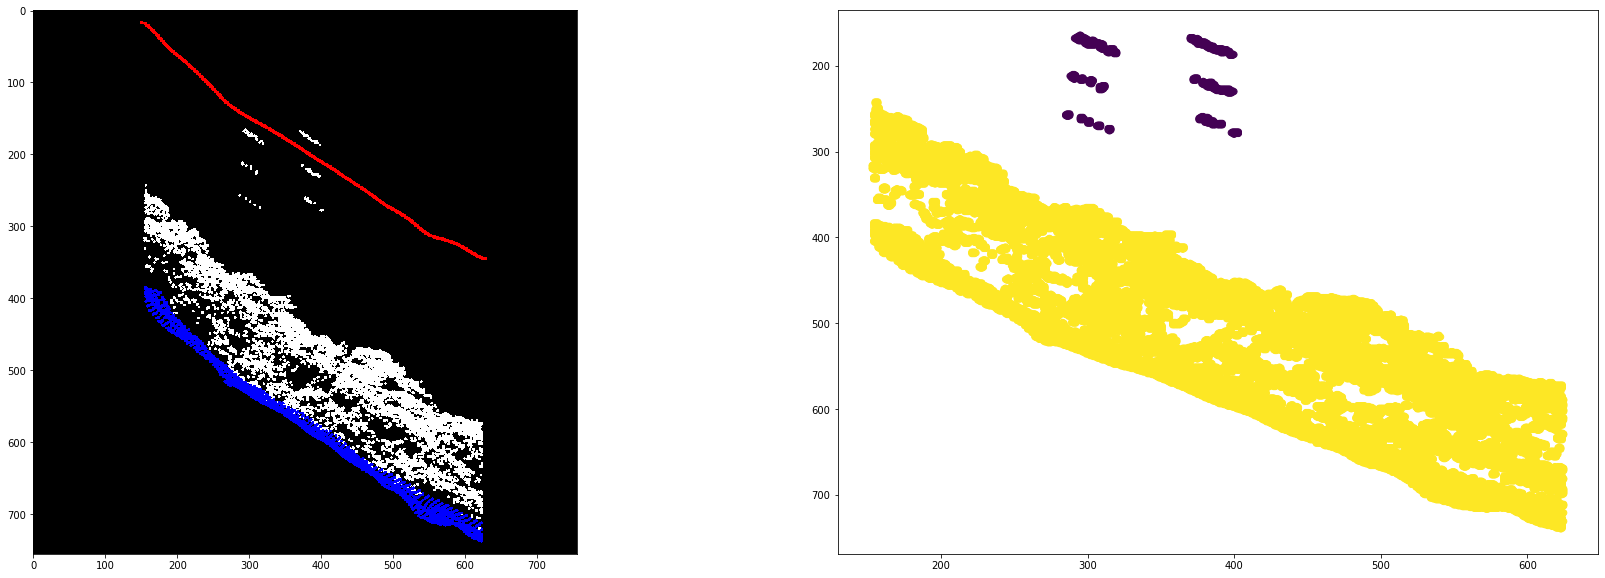

In [446]:
file='9622-1-062_001.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


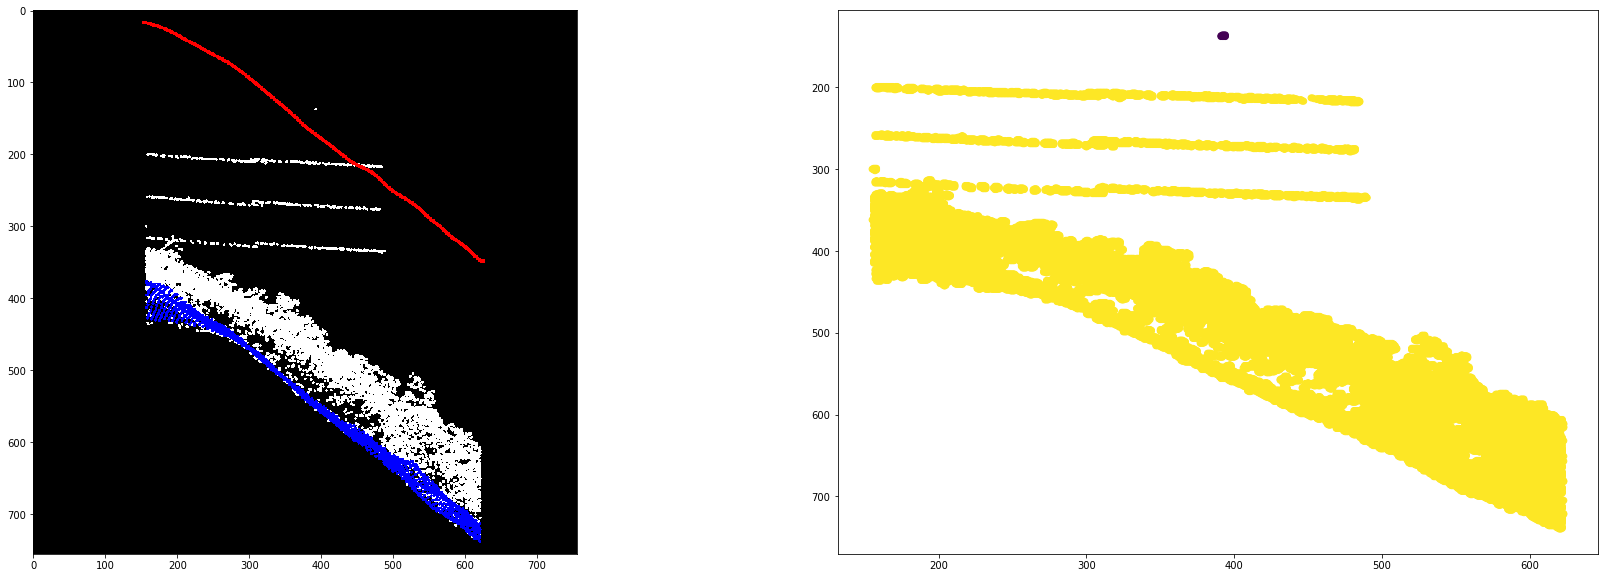

In [447]:
file='9622-1-065_009.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


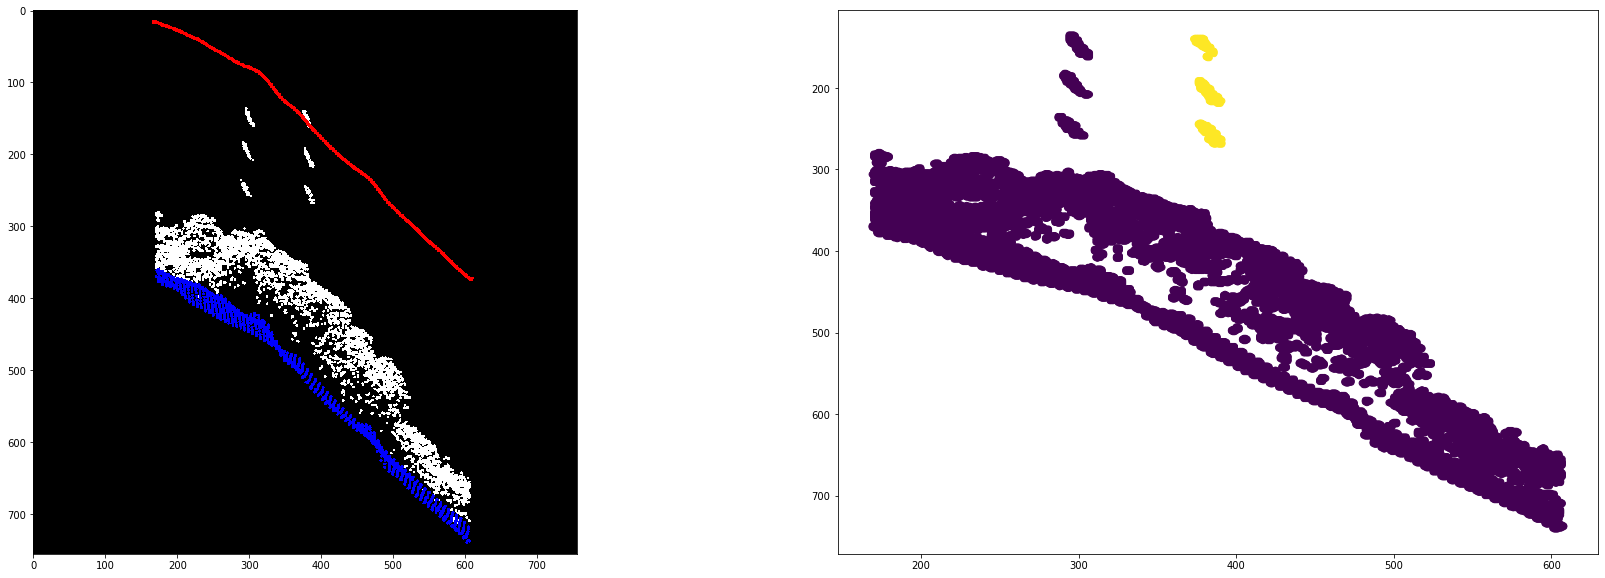

In [448]:
file='9622-1-082_012.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


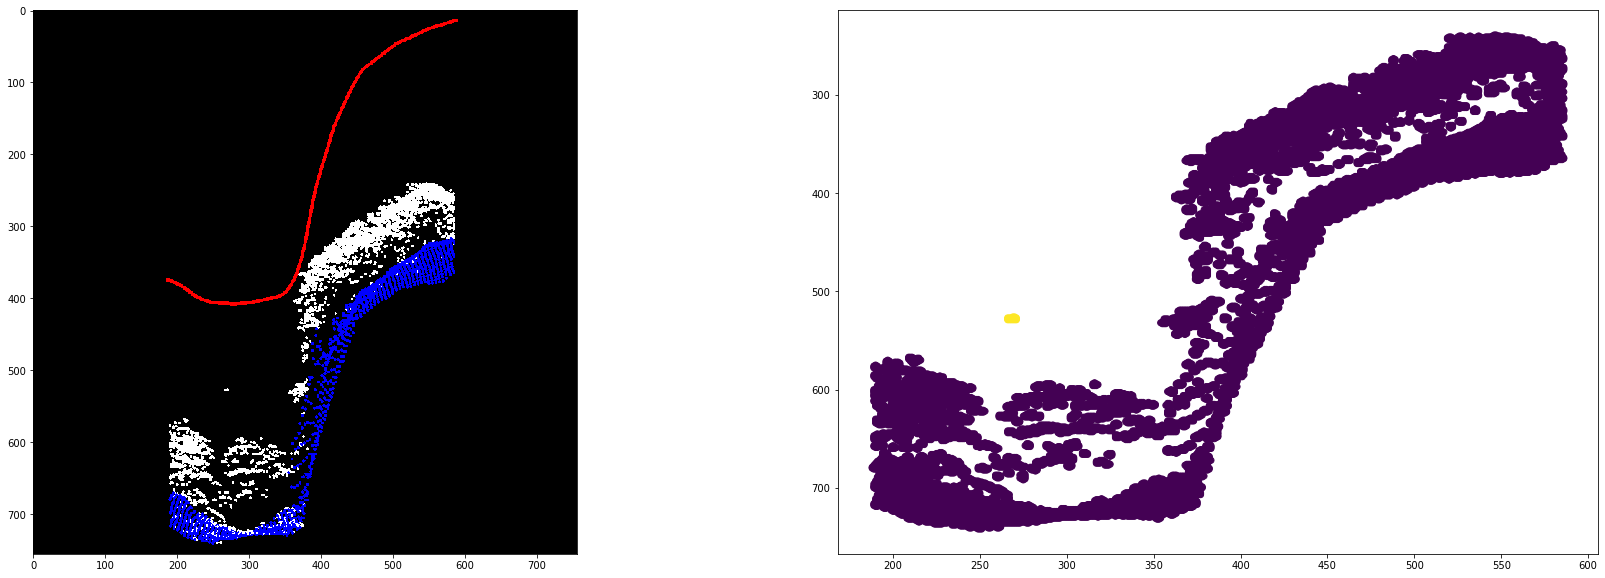

In [449]:
file='9622-1-094_001.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


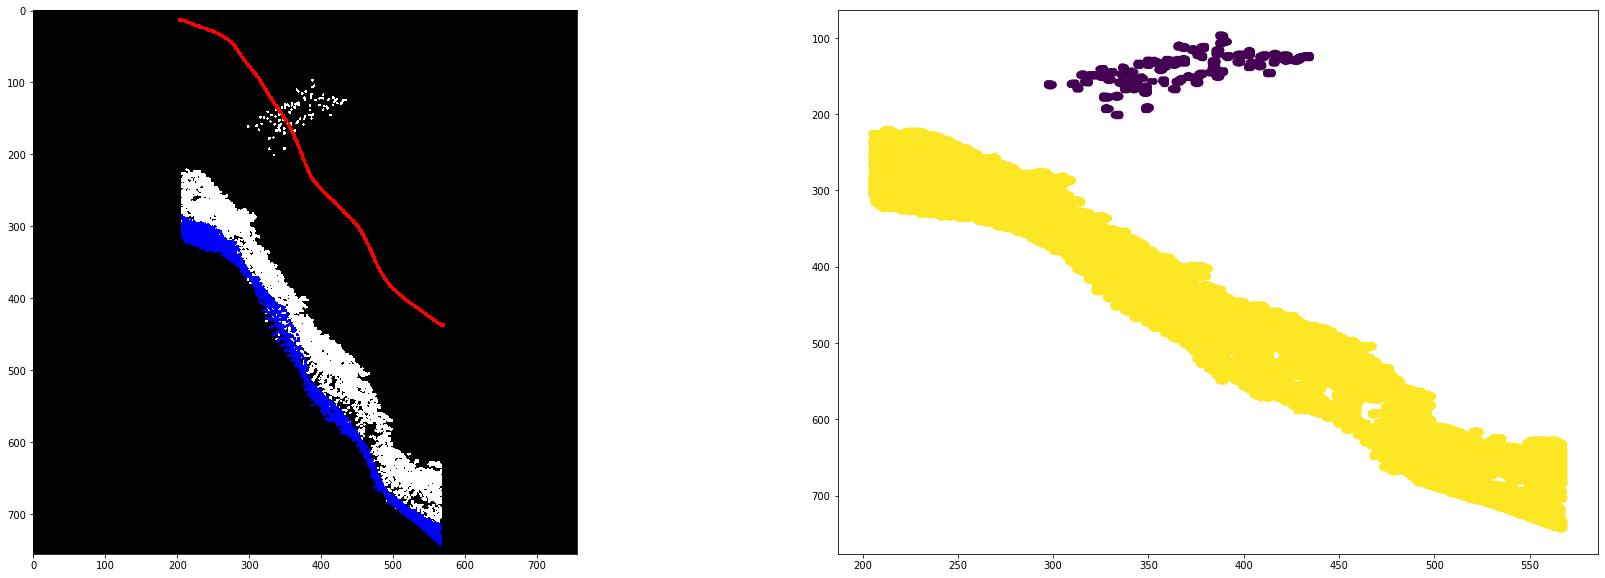

In [450]:
# 9622-2-002_004~006 疑似一群鴿子
file='9622-2-002_004.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1, 2}


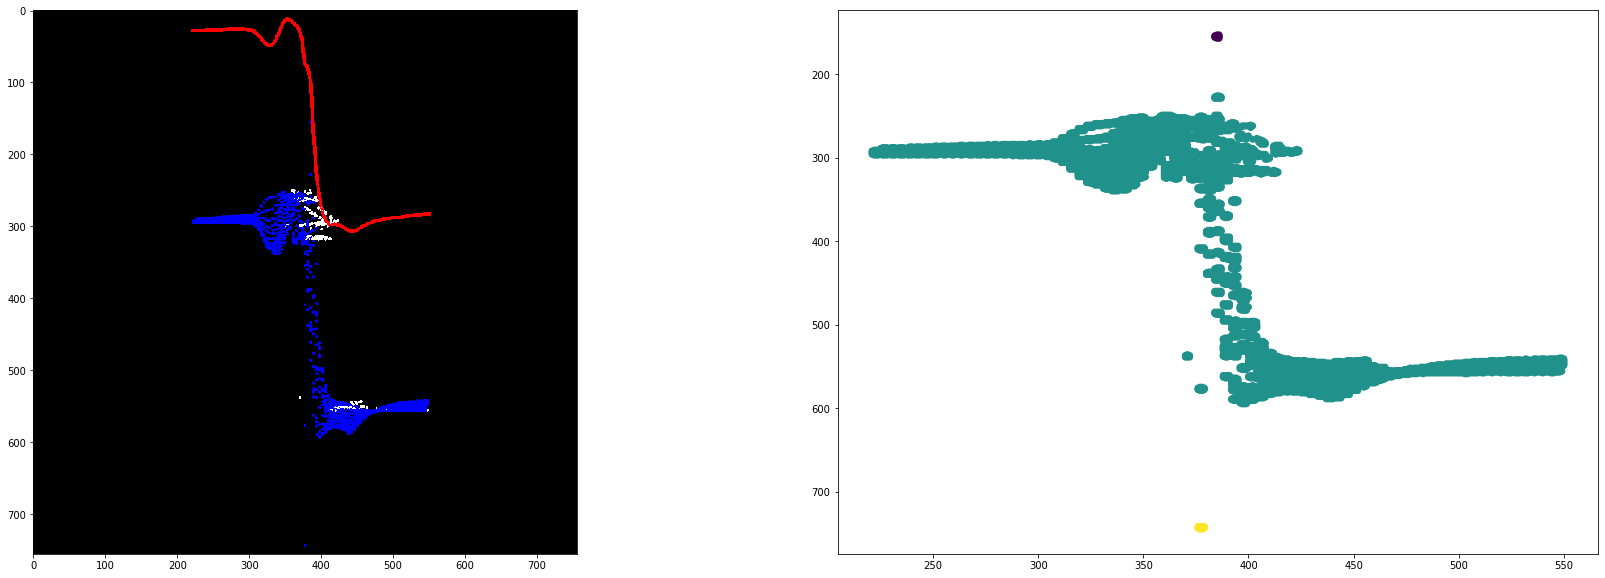

In [451]:
# 9622-2-004_013~18 基準線異常
# 基準線異常分離
file='9622-2-004_017.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


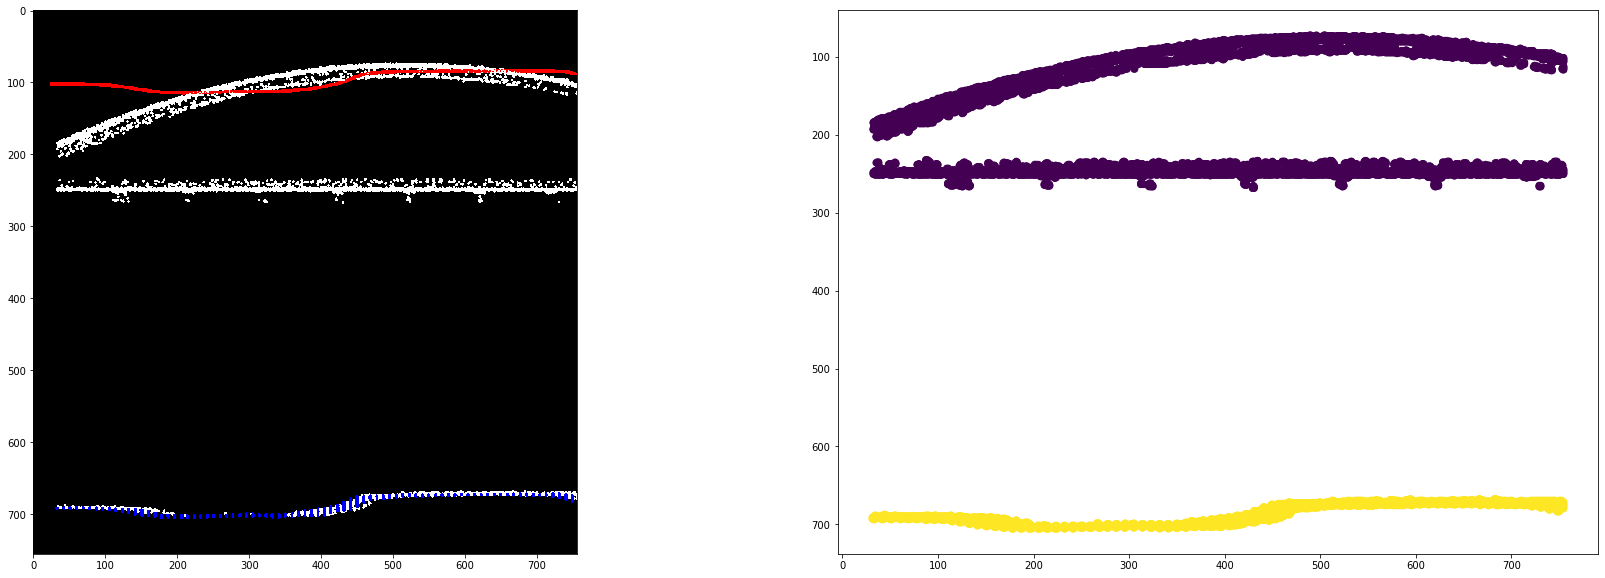

In [452]:
# 疑似橋梁
file='9622-2-025_001.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0}


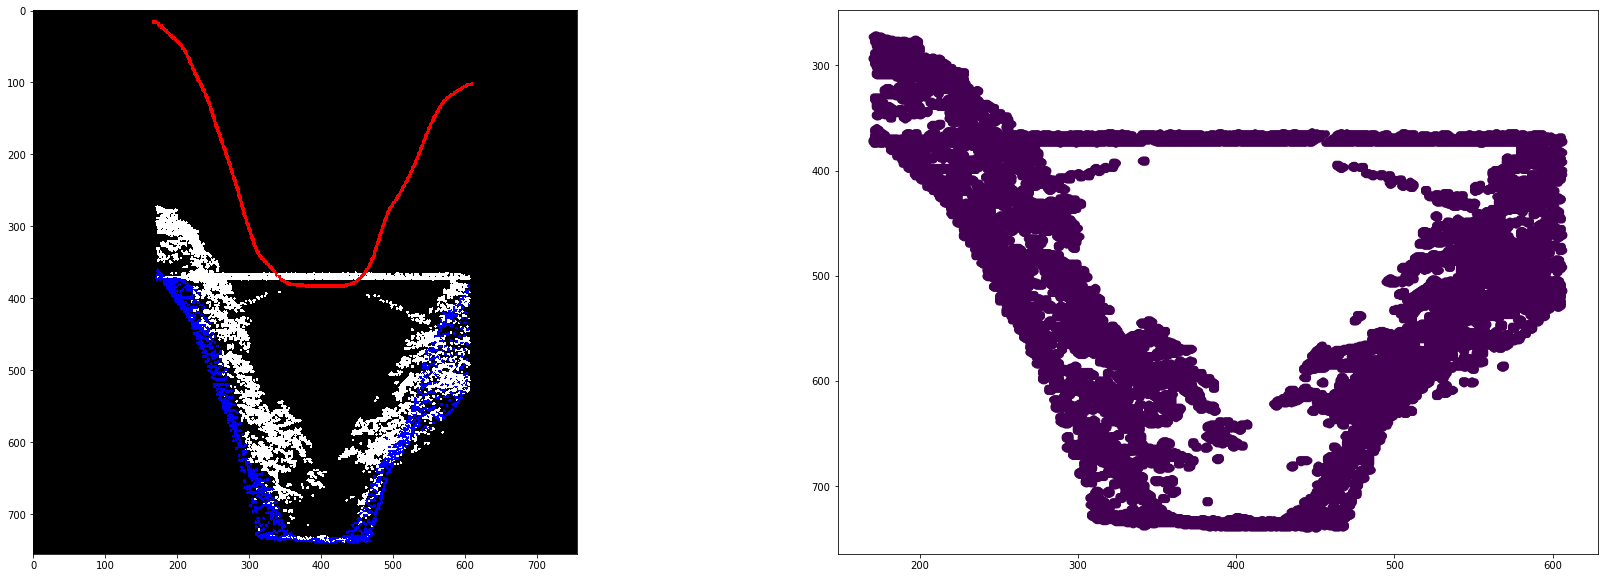

In [453]:
file='9622-2-026_015.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0}


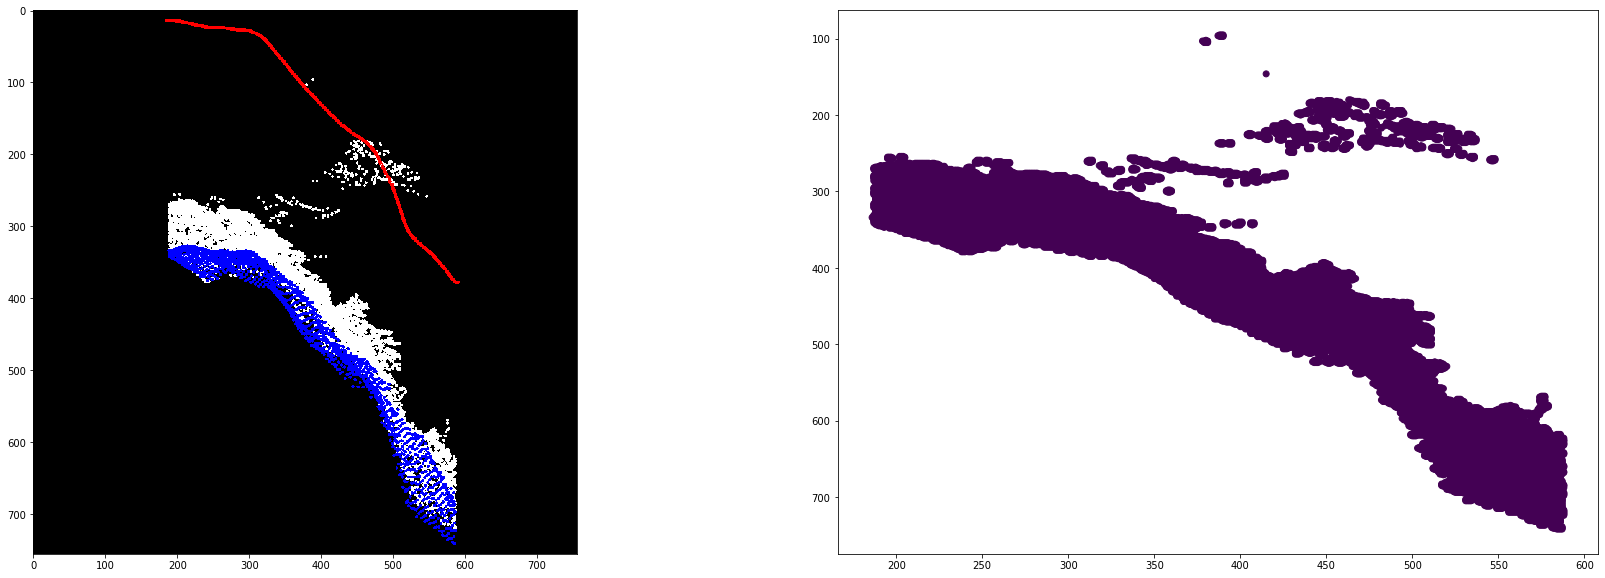

In [454]:
# 9622-2-029_019~44 空中不明一群物體 (無基準線, 顧慮調ok)
file='9622-2-029_019.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, -1}


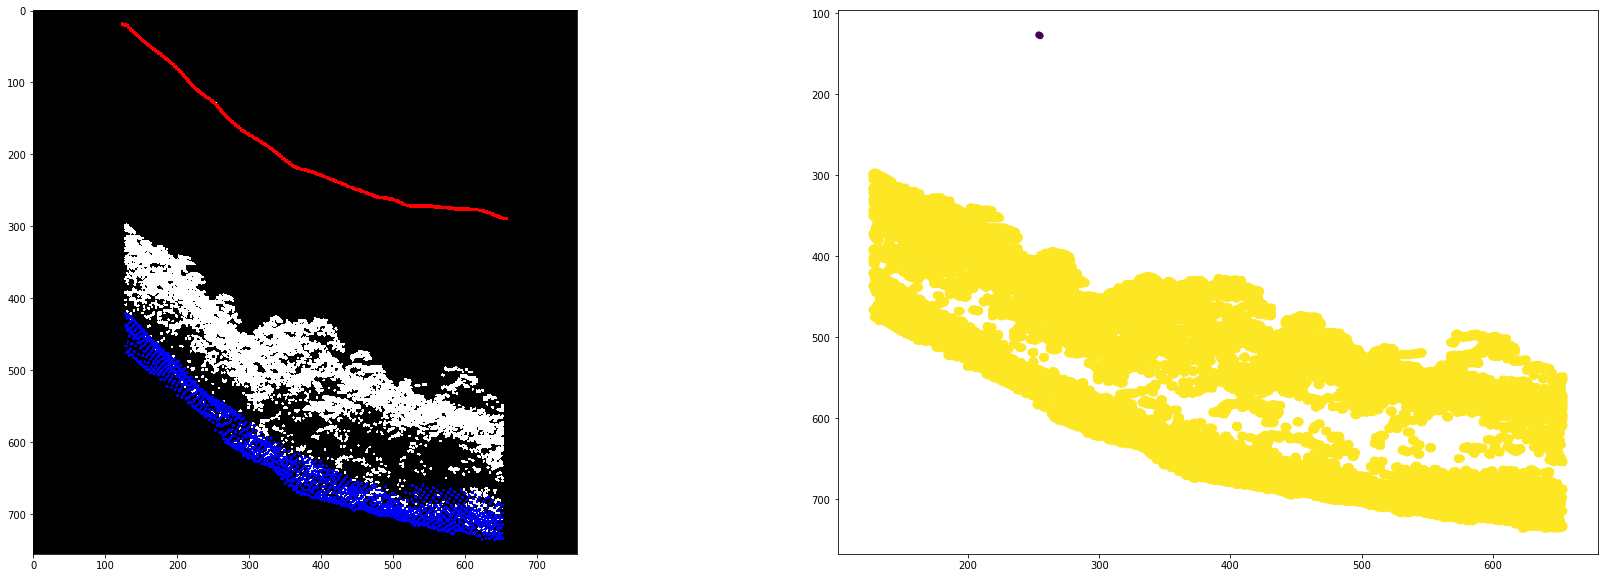

In [455]:
file='9722-1-031_005.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


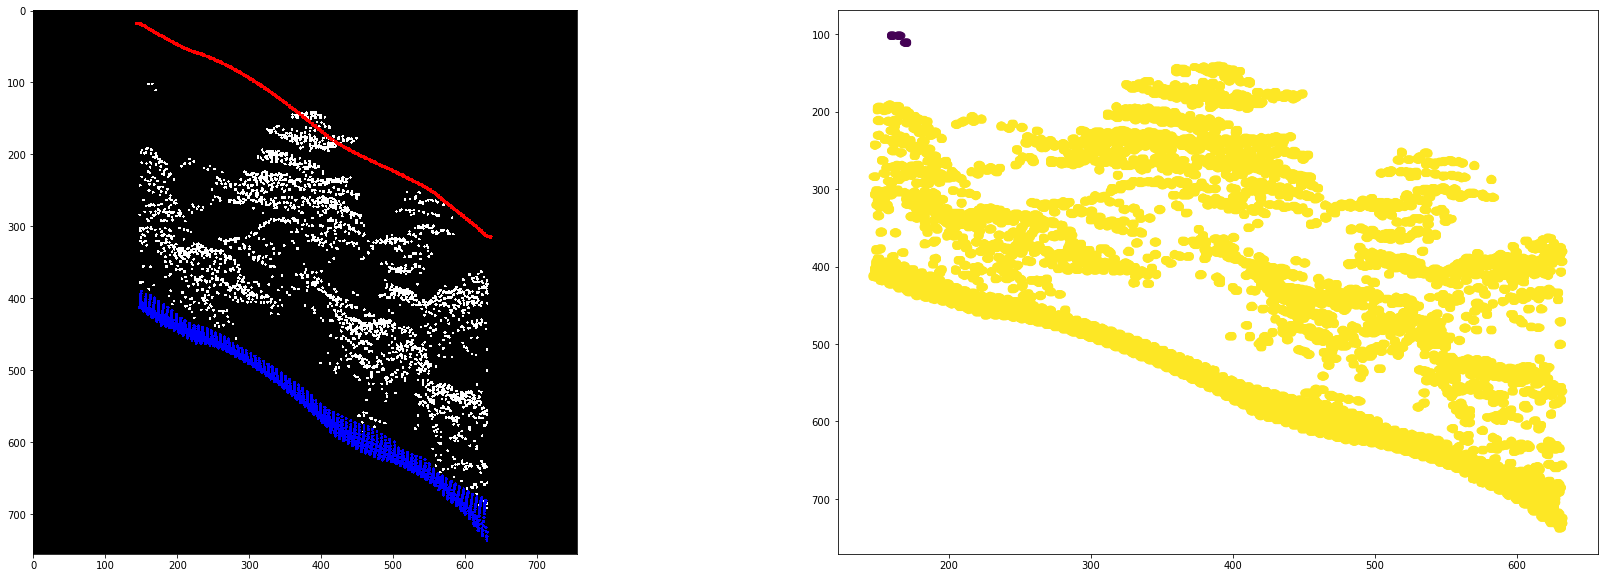

In [17]:
file='9518-1-066_034.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0}


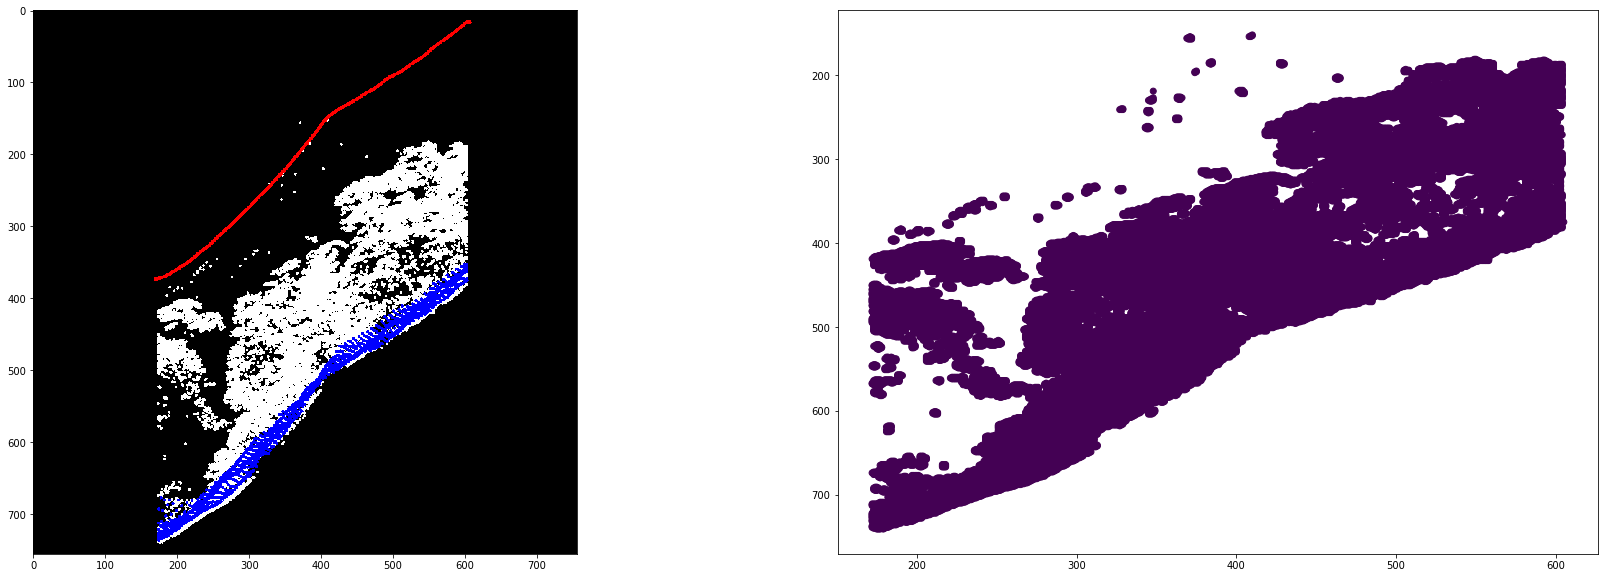

In [18]:
# 9518-2-051_001~010:疑似一群鳥
file='9518-2-051_001.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


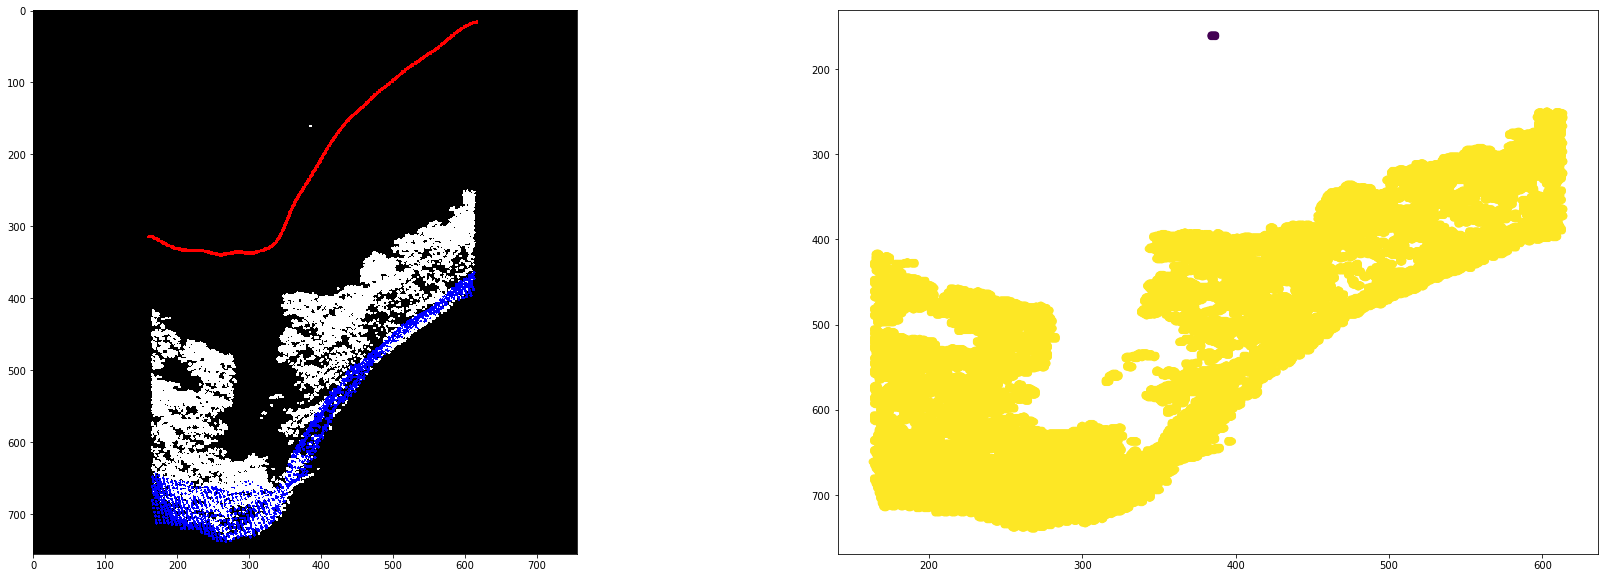

In [19]:
file='9518-1-099_130.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


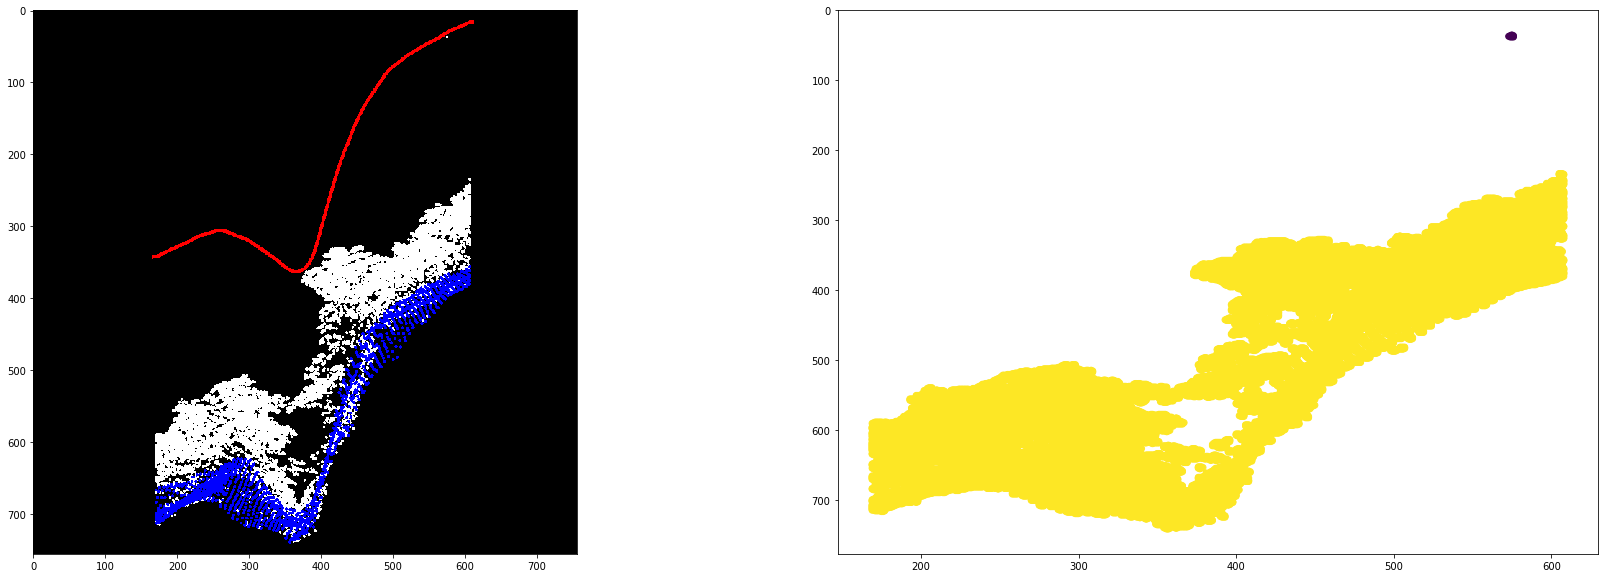

In [9]:
file='9518-2-028_046.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0}


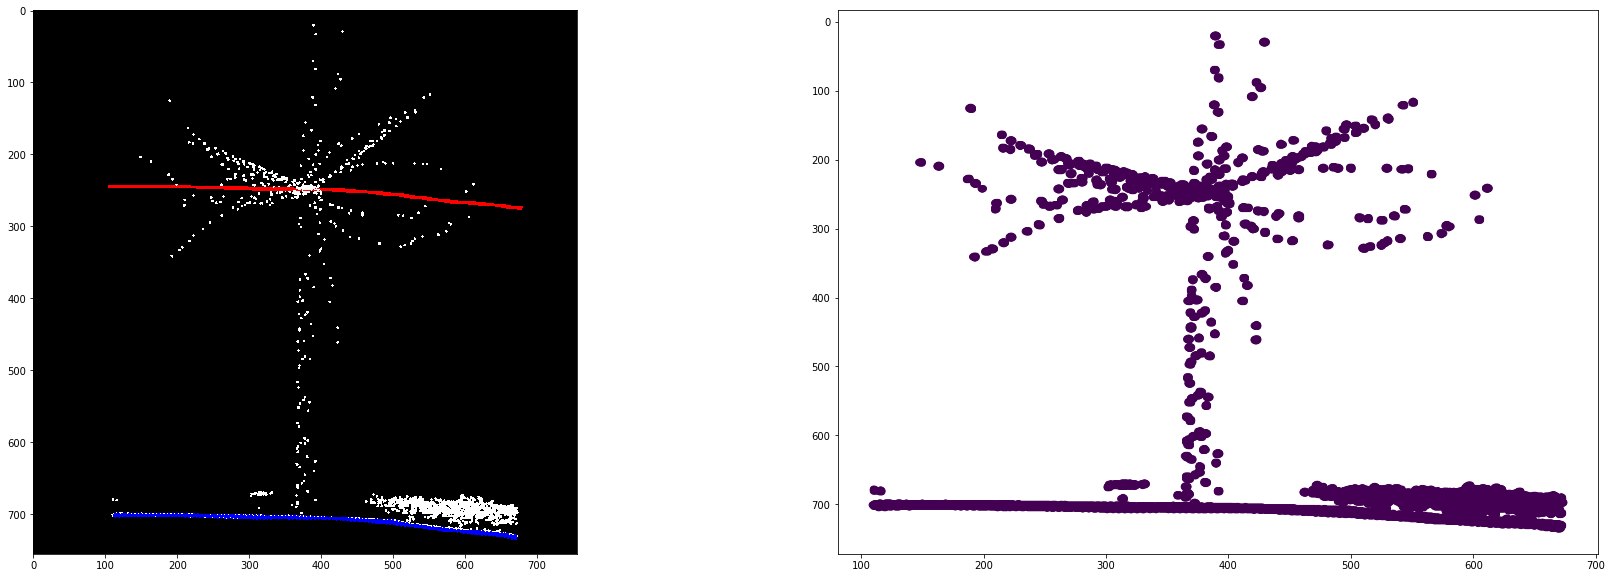

In [7]:
file='9516-4-020_004.png'
img0=cv2.imread(path+file)
img0 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img0)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(imgp)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

### 異常基準點Case:

{0, 1}


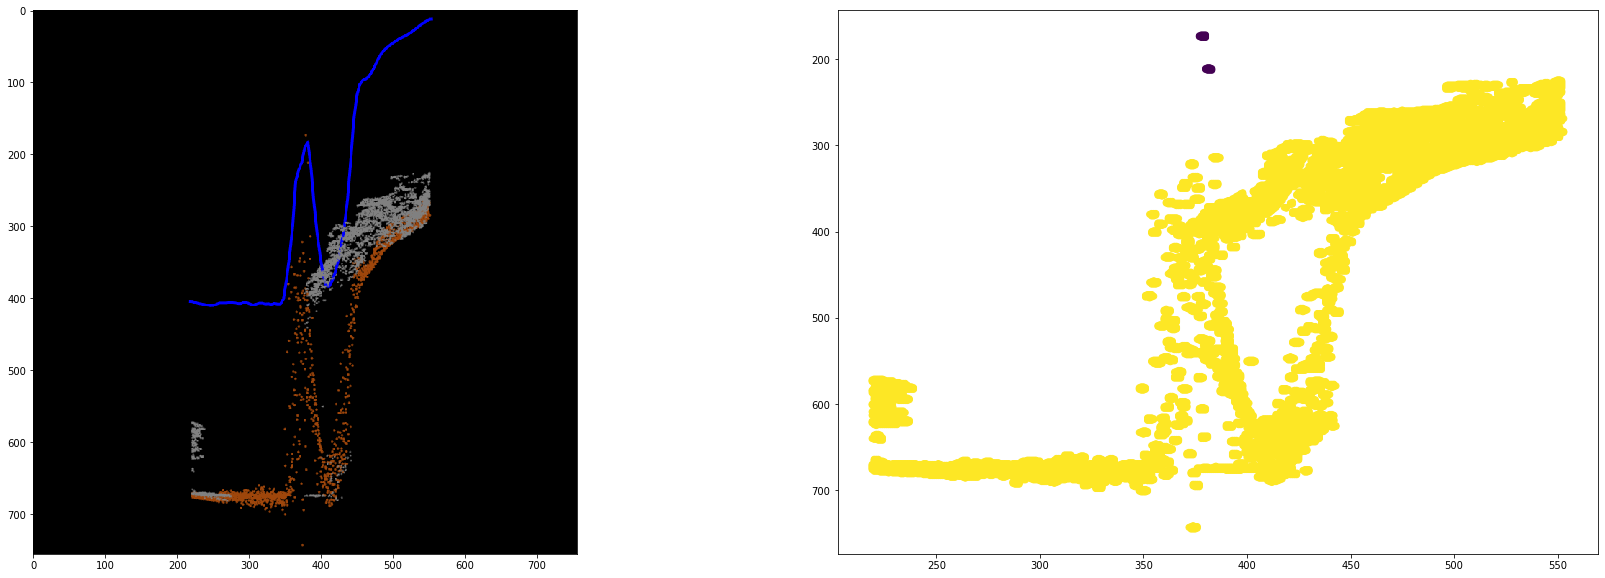

In [16]:
path = './all/'
file='9518-2-029_092.png'
img0=cv2.imread(path+file)
img1 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img1)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))

{0, 1}


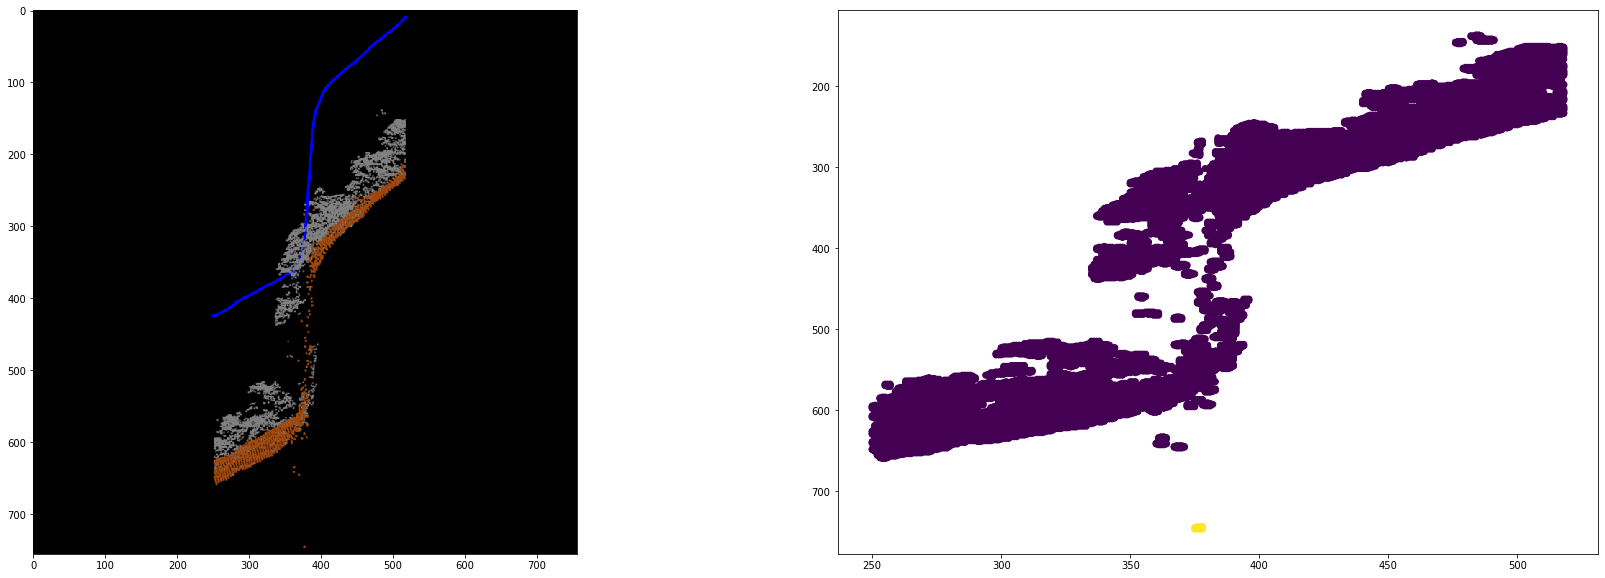

In [17]:
file='9619-1-001_074.png'
img0=cv2.imread(path+file)
img1 = img0[ : , : , (2, 1, 0)]
imgp=img_pre(img1)
X=coor(imgp)
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
ax = plt.gca() 
ax.invert_yaxis()
y_pred = DBSCAN(eps = 64).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
print(set(y_pred))